In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('/home/jovyan/work')

import logging
import segyio
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import gc
from tqdm.notebook import tqdm

from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize
from scipy.signal import butter, sosfilt
from devito import *
from copy import deepcopy
from distributed import Client, wait, LocalCluster
from skimage.metrics import structural_similarity as ssim

from examples.seismic import AcquisitionGeometry
from examples.seismic.acoustic import AcousticWaveSolver

from devito_ta.model_geom import get_model, get_geometry, grad_utils
from devito_ta.prepro import Filter, filter_data, CustomSource
from devito_ta.simulation_born_ms import fm_multi_shots, grad_multi_shots, born_multi_shots, normalize
from devito_ta.prepro_dl import train, prepare_data
from devito_ta.plotting import plot_shotrecord_cust, plot_velocity_cust, plot_acquisition_geometry, plot_freq
from deeplearning_ta.unet import *


configuration['log-level'] = 'WARNING'
configuration['opt'] = 'advanced'
logging.getLogger('distributed.nanny').setLevel(logging.ERROR)

In [2]:
file = 'vp_marmousi-ii_10m.segy'

with segyio.open(file, "r", ignore_geometry=True) as ss:
    n_traces = ss.tracecount
    sample_rate = segyio.tools.dt(ss) / 1000
    n_samples =ss.samples.size
    twt = ss.samples
    data = ss.trace.raw[:] 

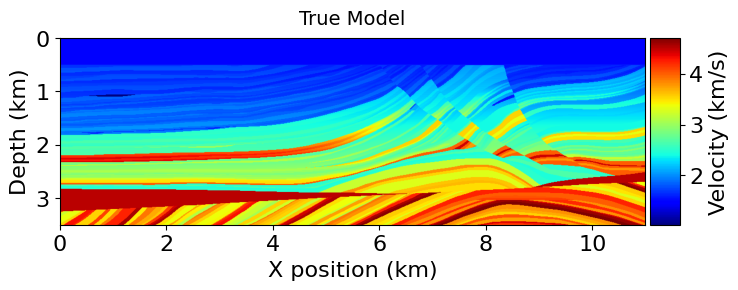

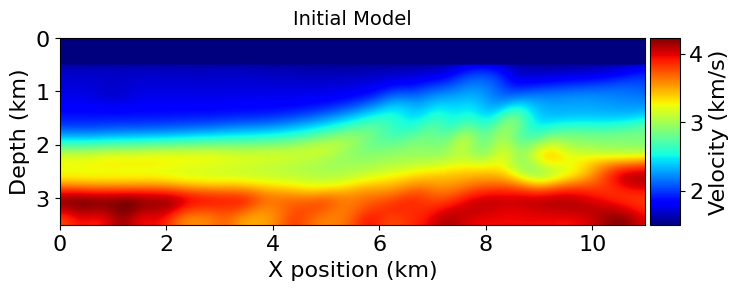

In [3]:
# Define water bottom depth in grid
wb = 50

# Define the model
v = data[200:13100, wb:].copy()             # Remove water layer
minv=v.min()
maxv=v.max()

# Add water bottom to initial model
water_btm = np.ones((v.shape[0], wb)) * 1.5
v = np.concatenate([water_btm, v], axis=1)

# Create initial model
init = gaussian_filter(v, sigma=[20, 20])  
init[:, :wb] = water_btm

init = np.clip(init, a_min=minv, a_max=maxv)

# Get model

shape = (1100, 351)
spacing = (10, 10)
origin = (0, 0)

model1 = get_model(np.clip(v, minv, maxv), shape, spacing, origin)
model0 = get_model(init, shape, spacing, origin)

# Plot velocity model
plot_velocity_cust(model1, colorbar=True, save=False, title='True Model', name='true_model')
plot_velocity_cust(model0, colorbar=True, save=False, title='Initial Model', name='init_model')


In [4]:
model1.critical_dt

np.float32(1.18)

In [5]:
# Create new geometry for 50 shots
par = {'nx':1100,          'dx':10,       'ox':0,
       'nz':351,          'dz':10,       'oz':0,
       'ns':30,           'ds':300,      'os':2020.0,  'sz':0,
       'nr':200,          'dr':10.0,     'or':0,       'rz':0,
       'nt':4000,         'dt':1.18,        'ot':0,       'nof':20,
       'freq':10,
      }

# Sampling frequency
fs = 1 / (par['dt']/1000)
nbl = model1.nbl

# Axes
x = np.arange(par['nx']) * par['dx'] + par['ox']
z = np.arange(par['nz']) * par['dz'] + par['oz']
t = np.arange(par['nt']) * par['dt'] + par['ot']
tmax = t[-1]

# Sources
x_s = np.zeros((par['ns'], 2))
x_s[:, 0] = np.arange(par['ns']) * par['ds'] + par['os']
x_s[:, 1] = par['sz'] 

# Receivers
x_r = np.zeros((par['nr'], 2))
x_r[:, 0] = np.arange(par['nr']) * par['dr'] + par['or']
x_r[:, 1] = par['rz'] 

geometry1 = get_geometry(model=model1,
                         src_x=x_s[:, 0],
                         src_z=x_s[:, 1],
                         rec_x=x_r[:, 0],
                         rec_z=x_r[:, 1],
                         t0=0,
                         tn=par['nt'],
                         nof=par['nof'],
                         src_type='Ricker',
                         f0=par['freq']/1000,
                         dt=par['dt'])


n_workers = 6

cluster = LocalCluster(
    n_workers=n_workers,
    memory_limit='auto',
    threads_per_worker=4,
    death_timeout=3600
)

client = Client(cluster)
client.restart()

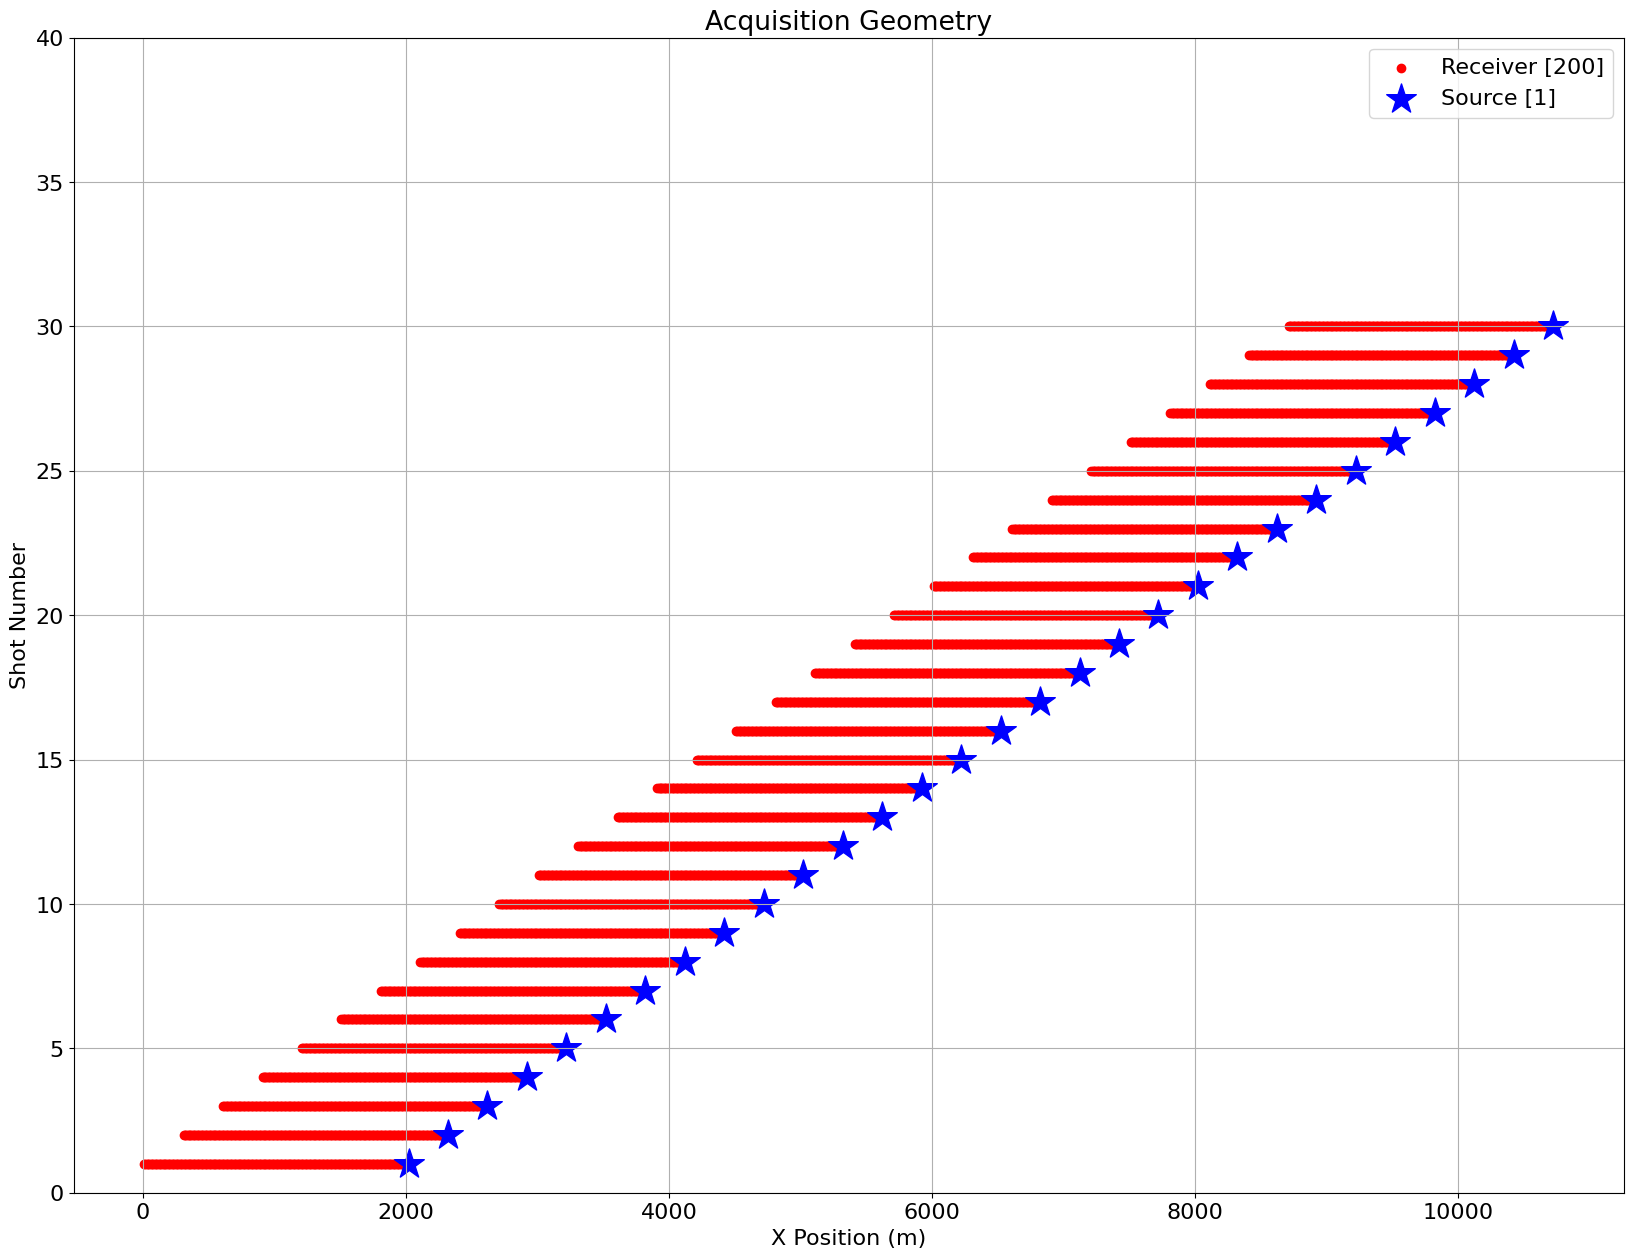

In [6]:
plot_acquisition_geometry(geometry1, 'Acquisition Geometry')

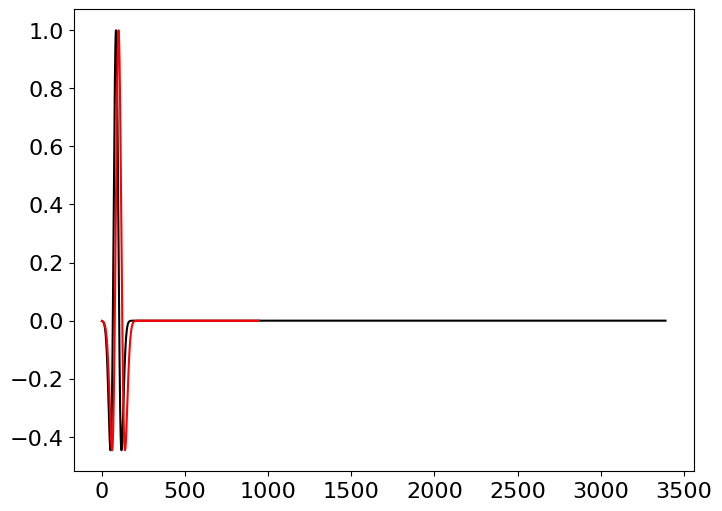

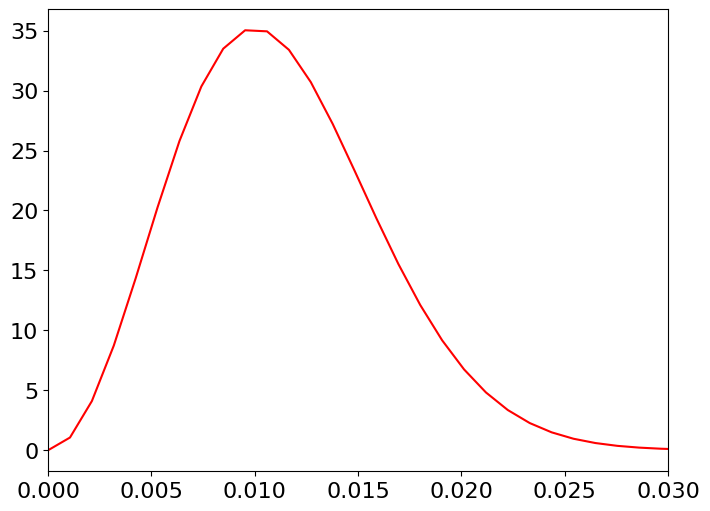

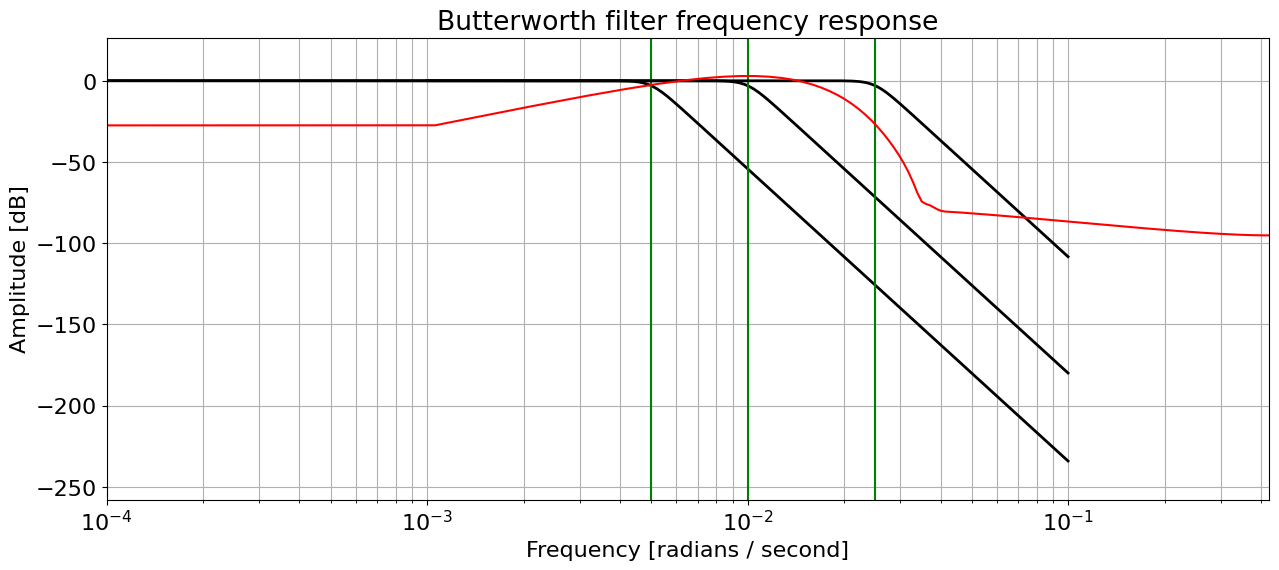

In [7]:
nwav = 800
wav = geometry1[1].src.wavelet

f = np.fft.rfftfreq(nwav, par['dt'])
WAV = np.fft.rfft(wav[:nwav], nwav)

plt.figure()
plt.plot(wav, c='k')
plt.plot(geometry1[1].time_axis.time_values[:nwav], wav[:nwav], c='r')

plt.figure()
plt.plot(f, np.abs(WAV), c='r')
plt.xlim(0, par['freq']*3/1000);

# Params (3stages)
frequencies = [0.005, 0.01, 0.025]
nfilts = [9, 9, 9]
ftol = [1e-10, 1e-10, 1e-10]
maxiter = [50, 50, 50]
maxfun = [200, 200, 200]


# Extract wavelet and pad it to allow filtering
wavpad = 400
wav = wav[:2*np.argmax(wav)+1]
wav = np.pad(wav, (wavpad, geometry1[0].nt - wavpad - wav.size))

# Define filter
nfft = 2**10

plt.figure(figsize=(15, 6))
Filt = Filter(frequencies, nfilts, par['dt'], plotflag=True)
plt.semilogx(f, 20*np.log10(np.abs(WAV)) - 28, 'r');

In [8]:
wavfilt = Filt.apply_filter(wav.squeeze(), ifilt=0)
src = CustomSource(name='src', grid=model1.grid,
                               wav=wavfilt, npoint=1,
                               time_range=geometry1[0].time_axis)
#geometry.src_positions[0, :] = (self.src[0][isrc], self.src[1][isrc])
#src.coordinates.data[0, :] = (self.src[0][isrc], self.src[1][isrc])


#plt.plot(wav)
#plt.plot(src.data)

#src.coordinates.data, geometry1[0].src.coordinates.data, geometry1[0].src_positions

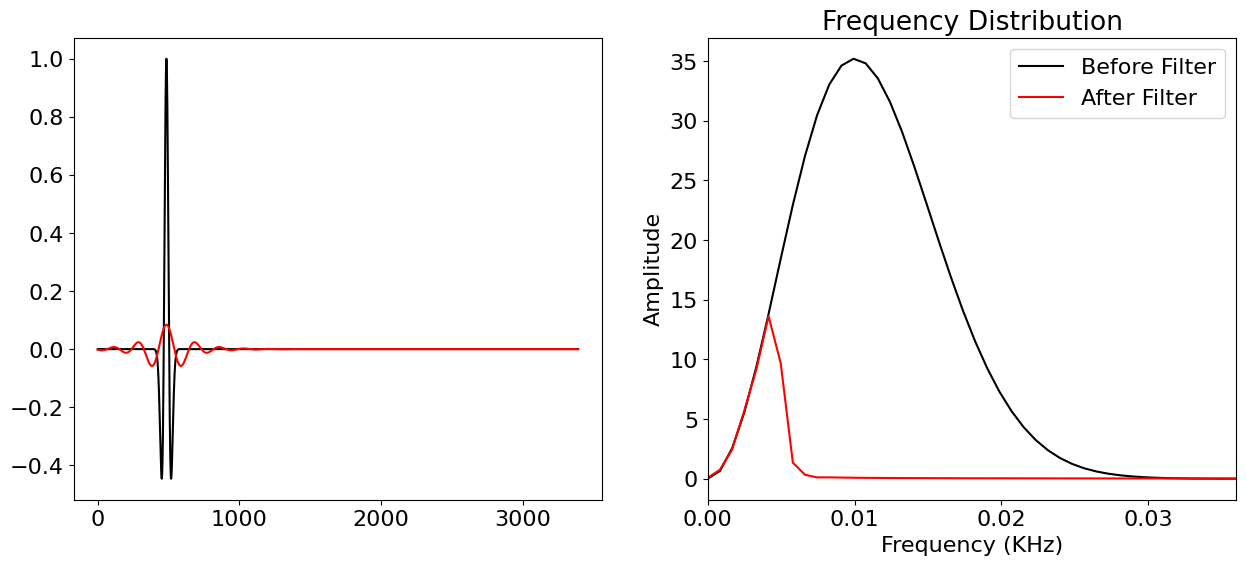

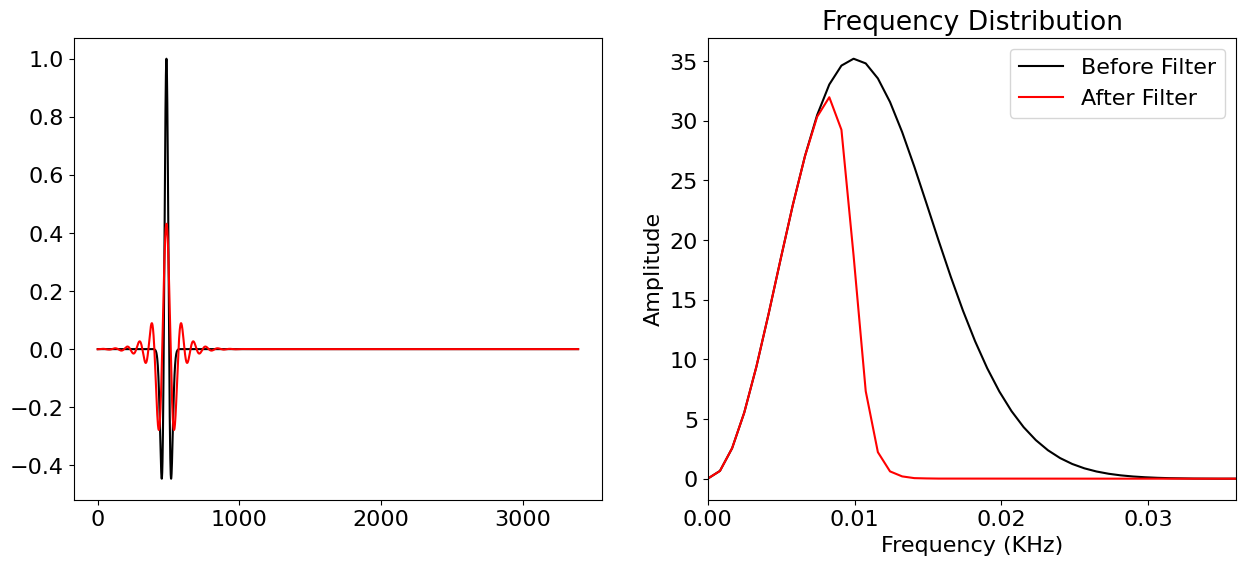

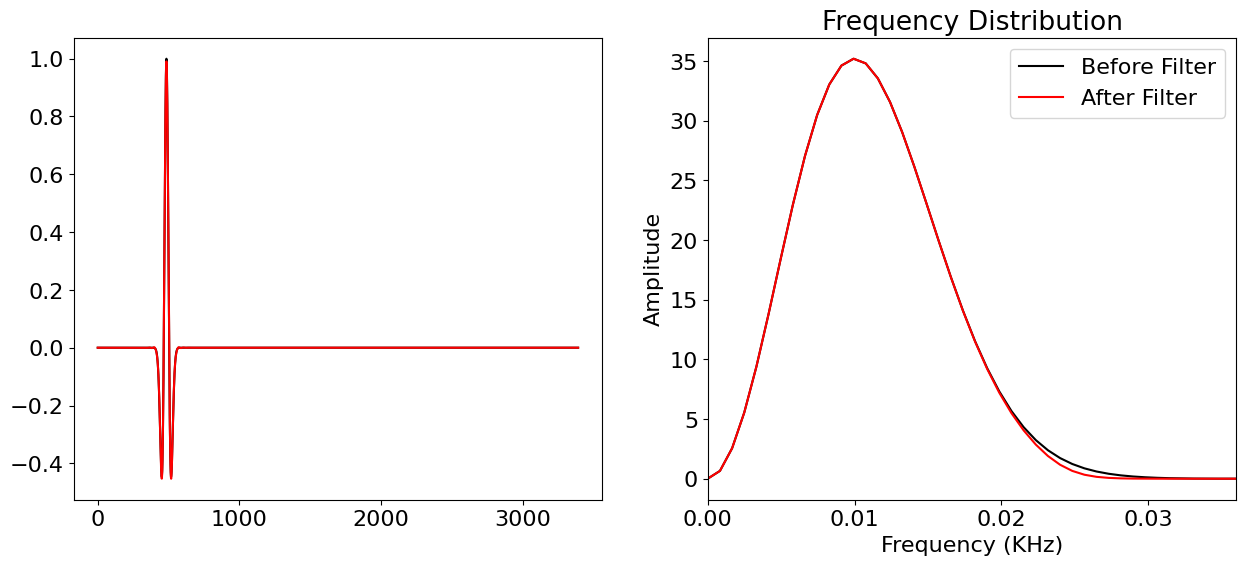

In [9]:
for i in range(len(frequencies)):
    
    wavfilt = Filt.apply_filter(wav.squeeze(), ifilt=i)
    
    
    f = np.fft.rfftfreq(nfft, par['dt'])
    WAV = np.fft.rfft(wav, nfft)
    WAVfilt = np.fft.rfft(wavfilt, nfft)
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    axs[0].plot(wav, 'k')
    axs[0].plot(wavfilt, 'r')
    axs[1].set_title('Frequency Distribution')
    axs[1].set_xlabel('Frequency (KHz)')
    axs[1].set_ylabel('Amplitude')
    axs[1].plot(f, np.abs(WAV), 'k', label='Before Filter')
    axs[1].plot(f, np.abs(WAVfilt), 'r', label='After Filter')
    axs[1].set_xlim(0, np.argmax(np.abs(WAV))/1000*3);
    plt.legend()
    

In [10]:
# Perform forward modelling at 10 Hz
dt = par['dt']

start_10hz = time.time()
fm = fm_multi_shots(model1, geometry1, n_workers, client, dt=dt)
finish_10hz = time.time()

duration_10hz = finish_10hz - start_10hz
print(f'Forward modelling duration for 30 shots: {(duration_10hz/60):.2f} minutes')

Operator `Forward` ran in 1.48 s
Operator `Forward` ran in 1.46 s
Operator `Forward` ran in 1.47 s
Operator `Forward` ran in 1.48 s
Operator `Forward` ran in 1.46 s
Operator `Forward` ran in 1.42 s
Operator `Forward` ran in 1.44 s
Operator `Forward` ran in 1.41 s
Operator `Forward` ran in 1.57 s
Operator `Forward` ran in 1.49 s
Operator `Forward` ran in 1.45 s
Operator `Forward` ran in 1.46 s
Operator `Forward` ran in 1.43 s
Operator `Forward` ran in 1.47 s
Operator `Forward` ran in 1.48 s
Operator `Forward` ran in 1.45 s
Operator `Forward` ran in 1.56 s
Operator `Forward` ran in 1.59 s
Operator `Forward` ran in 1.44 s
Operator `Forward` ran in 1.54 s
Operator `Forward` ran in 1.44 s
Operator `Forward` ran in 1.54 s
Operator `Forward` ran in 1.56 s
Operator `Forward` ran in 1.47 s
Operator `Forward` ran in 1.43 s
Operator `Forward` ran in 1.55 s
Operator `Forward` ran in 1.57 s
Operator `Forward` ran in 1.50 s
Operator `Forward` ran in 1.50 s
Operator `Forward` ran in 1.56 s


Forward modelling duration for 30 shots: 0.32 minutes


In [11]:
geometry1[1].src_positions[0][0].item()

2320.0

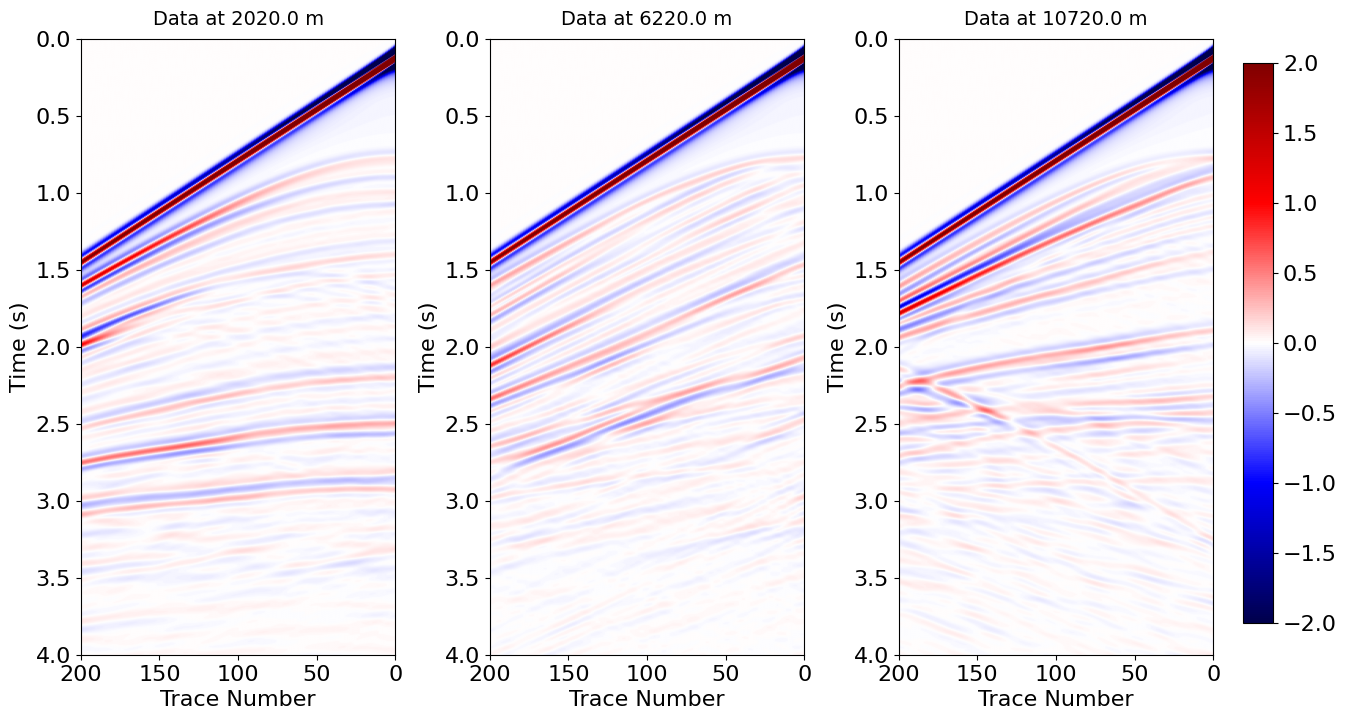

In [12]:
dobs = [d.data for d, _ in fm]

# Show unfiltered data
plot_shotrecord_cust(dobs[0].data, f'Data at {geometry1[0].src_positions[0][0].item()} m',
                     dobs[14].data, f'Data at {geometry1[14].src_positions[0][0].item()} m',
                     dobs[-1].data, f'Data at {geometry1[-1].src_positions[0][0].item()} m',
                     model=model1,
                     t0=geometry1[0].t0,
                     tn=geometry1[0].tn,
                     save=False,
                     colorbar=True)

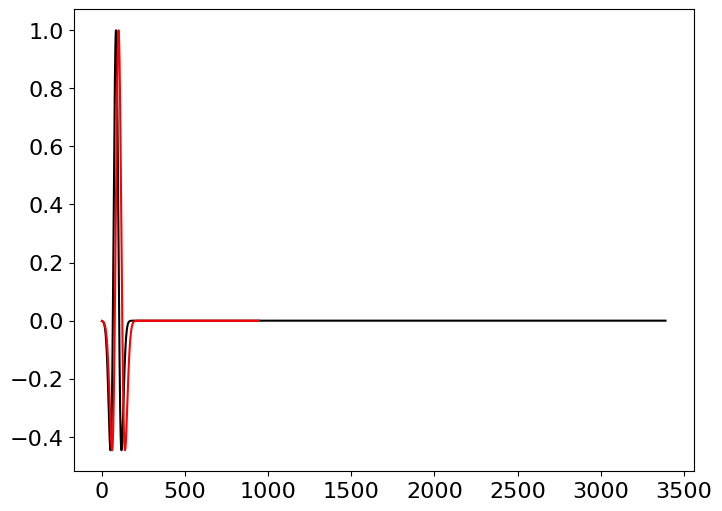

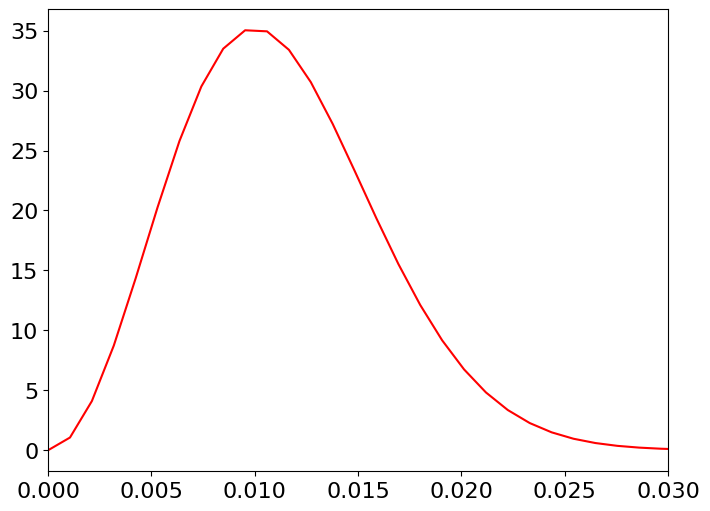

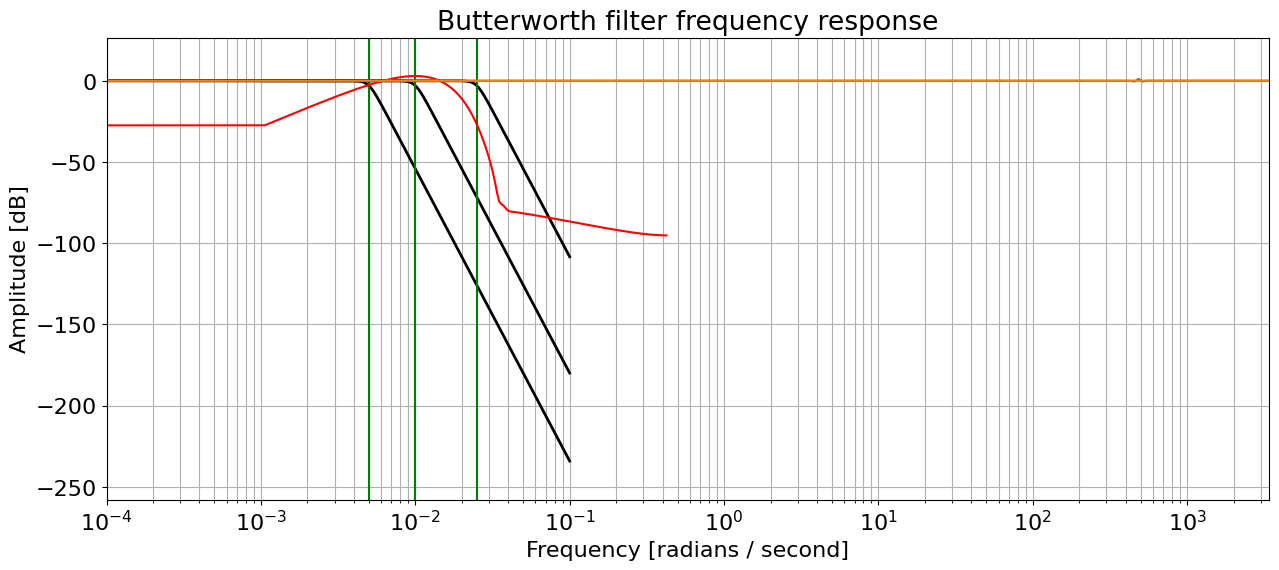

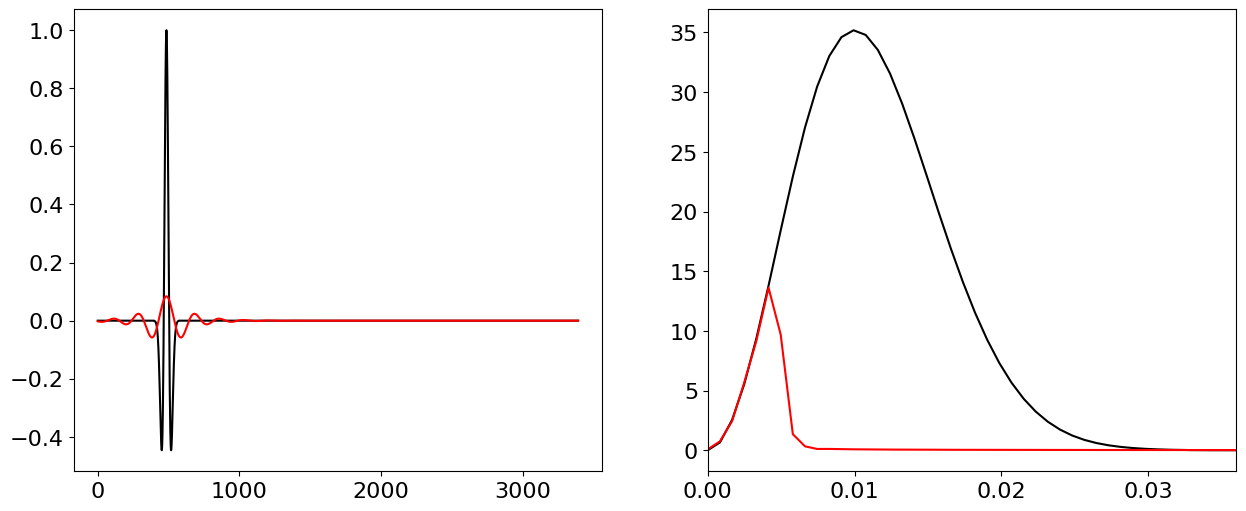

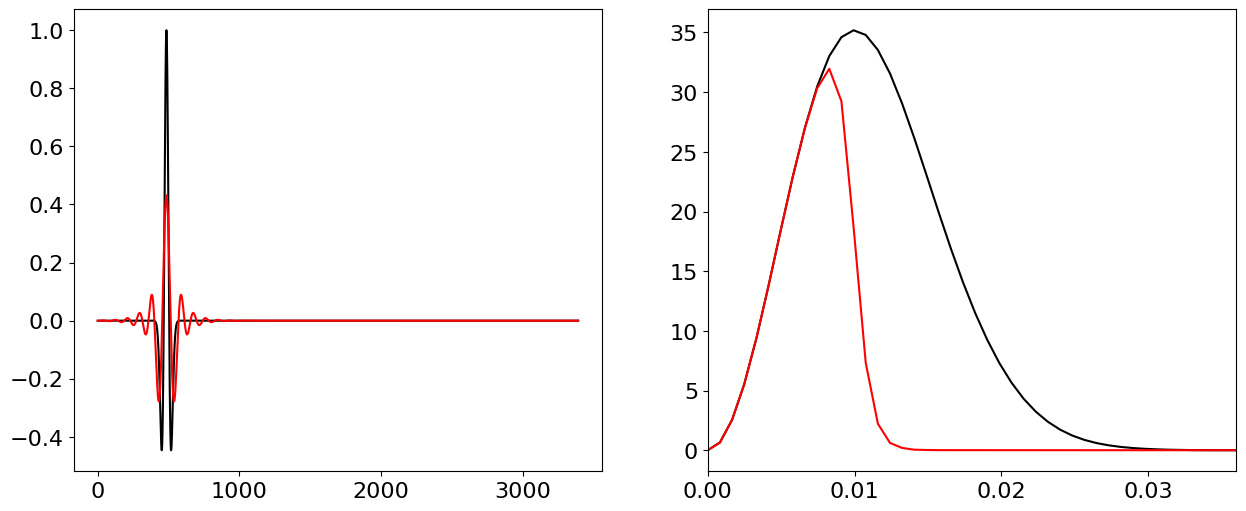

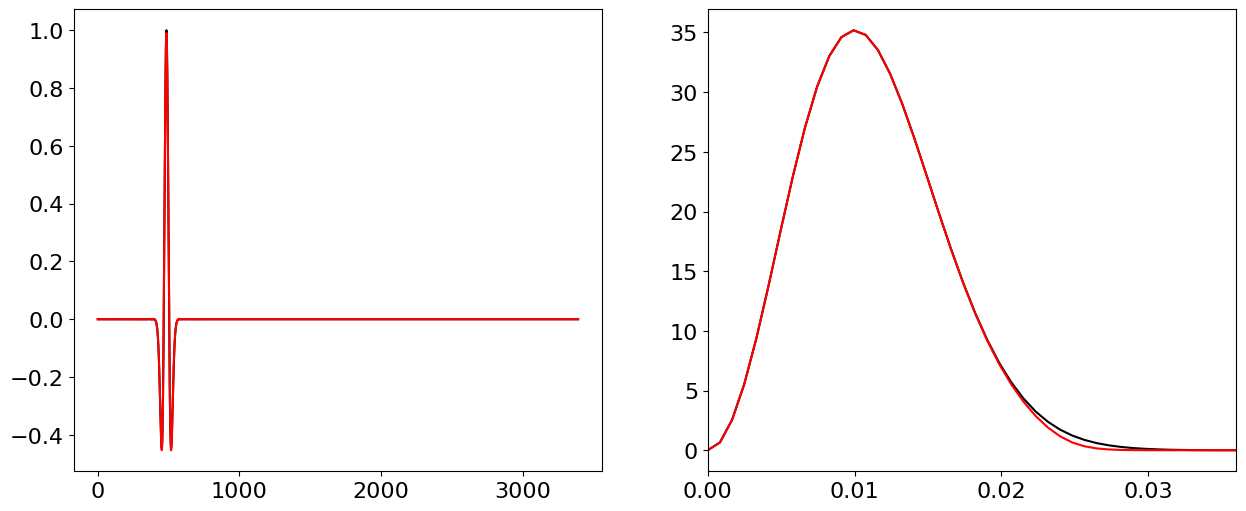

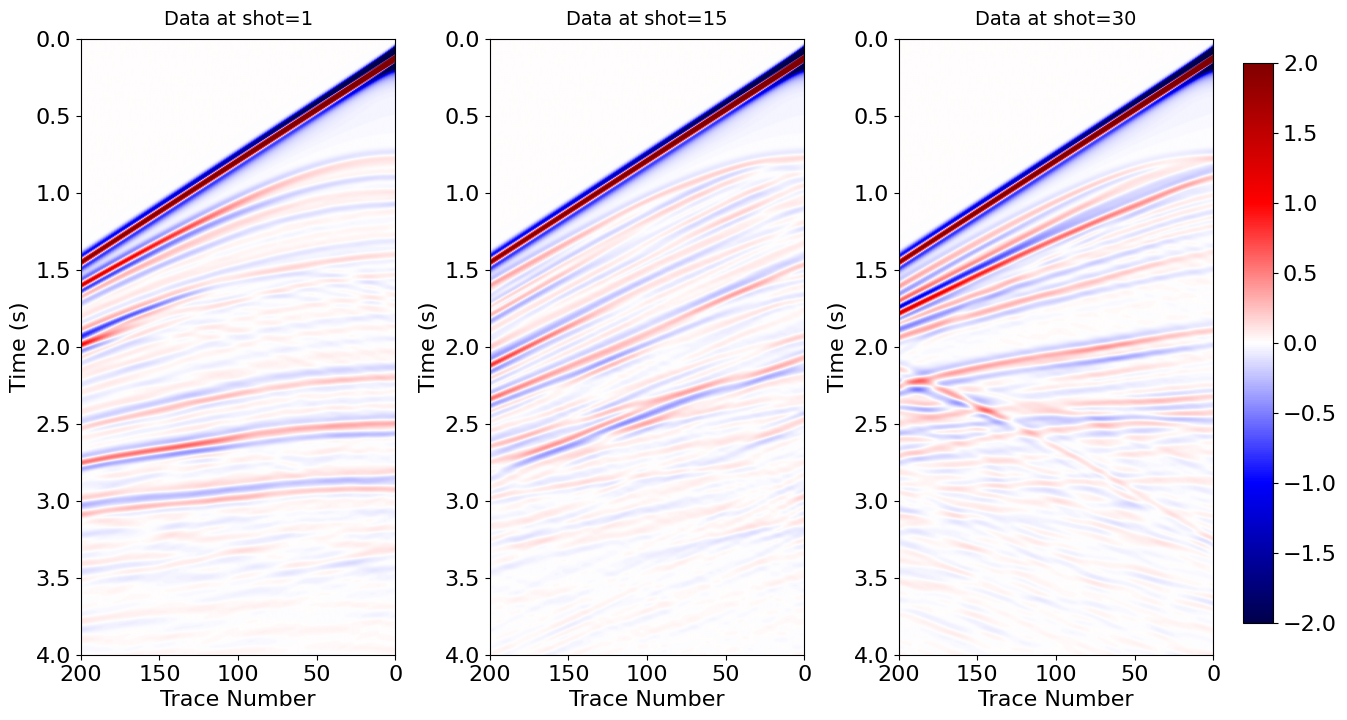

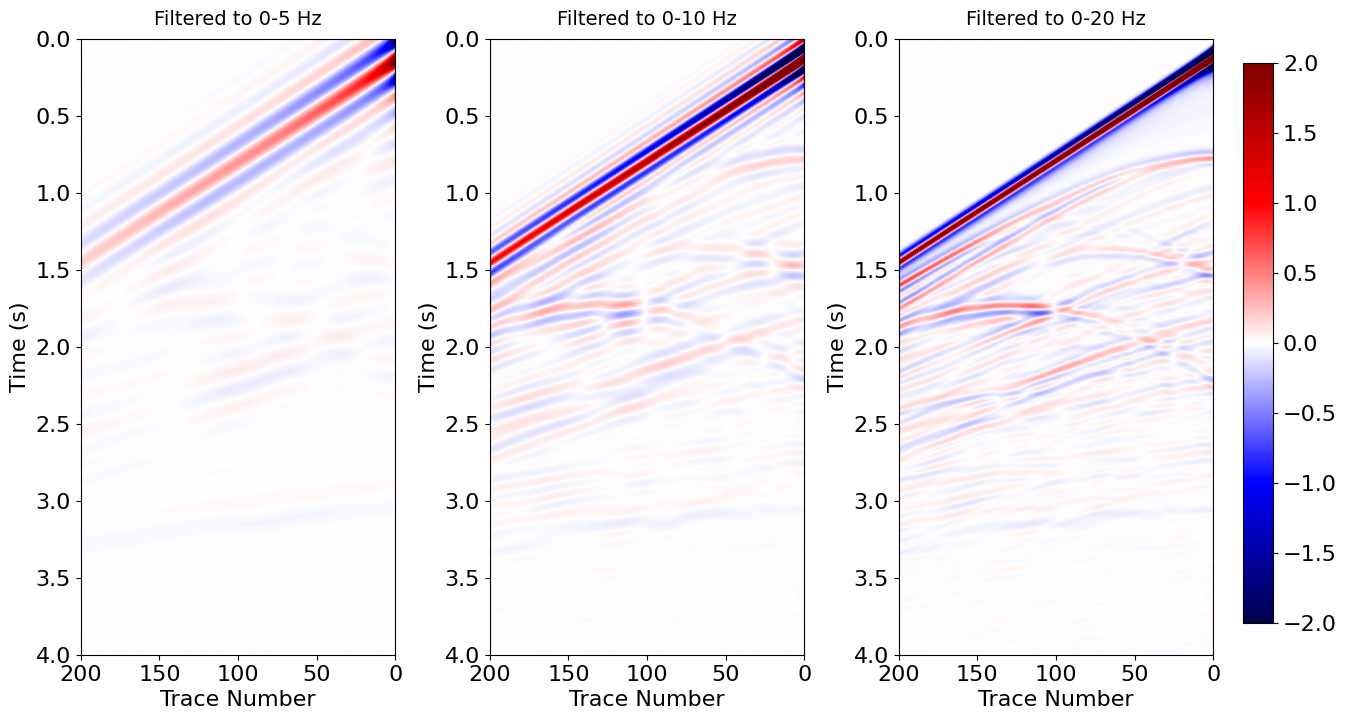

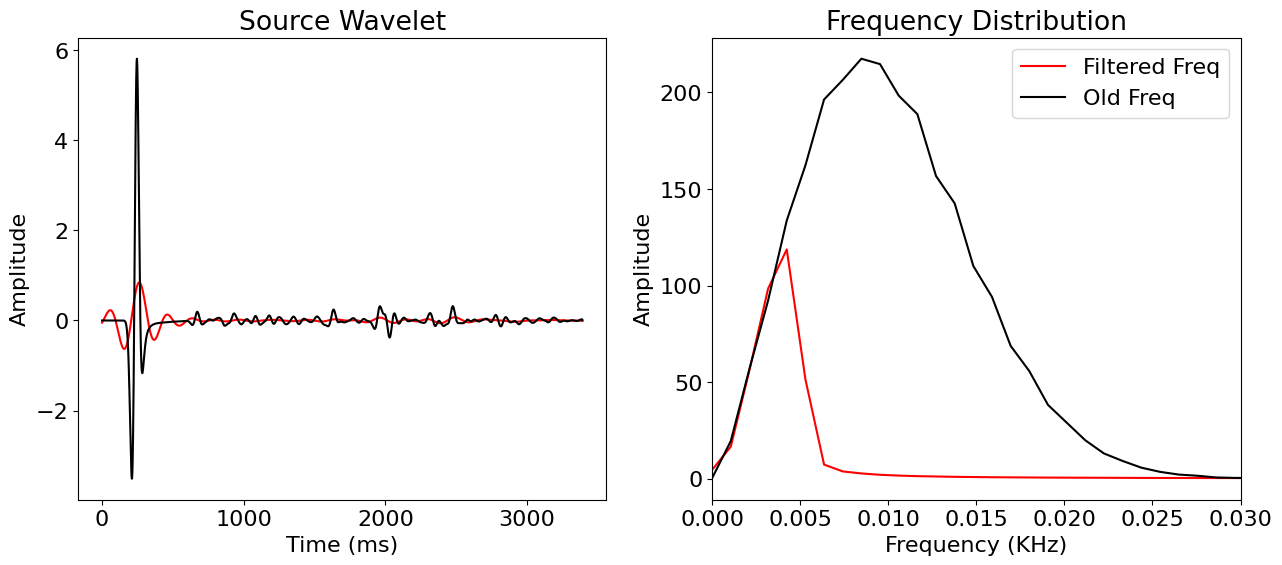

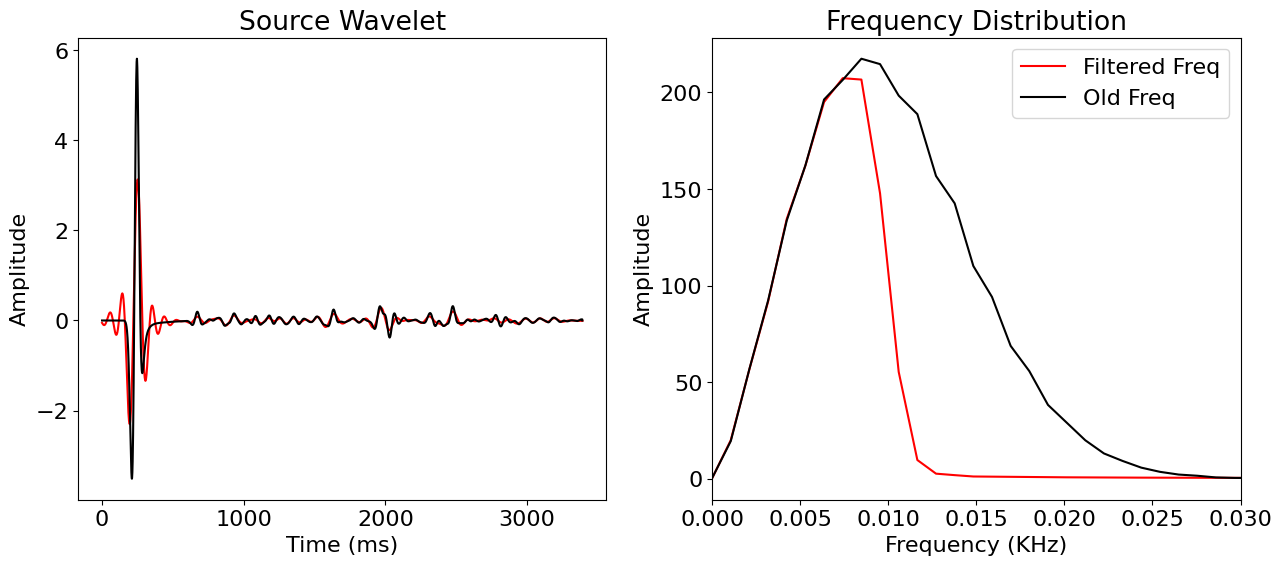

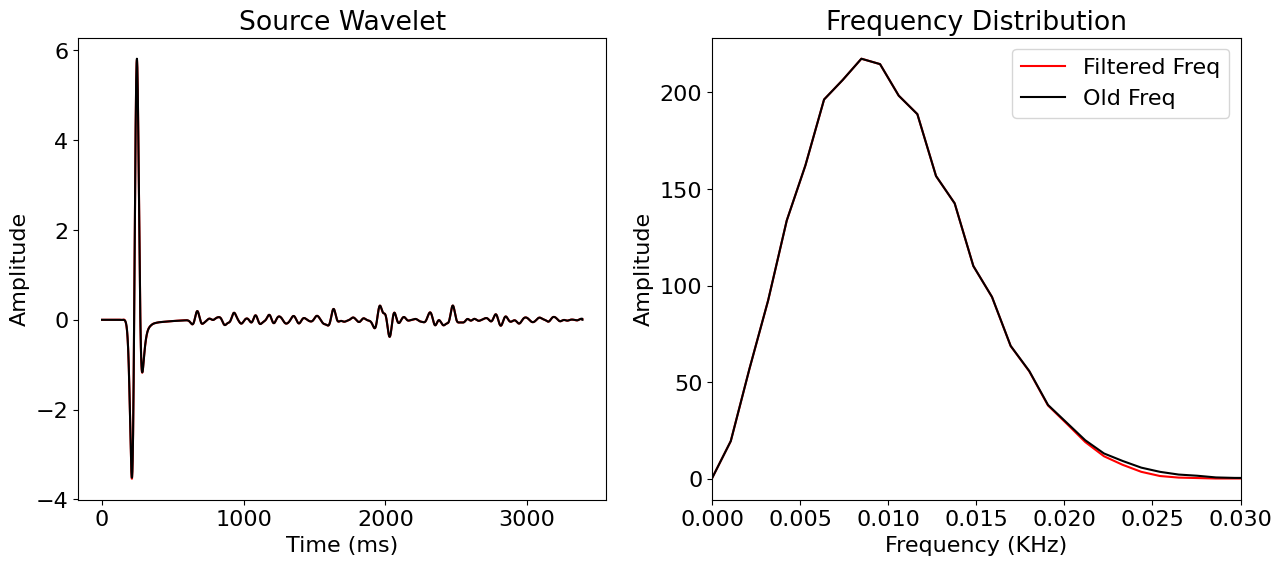

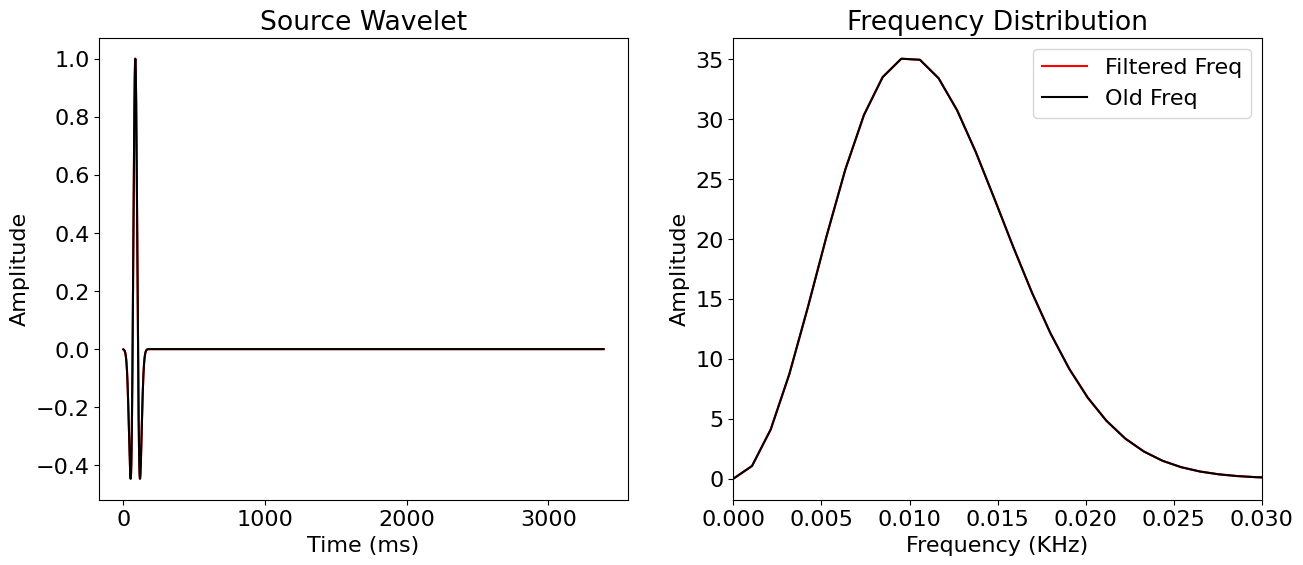

In [13]:
# Filtering

# Params (3stages)
frequencies = [0.005, 0.01, 0.025] #in KHz
nfilts = [9, 9, 9]
ftol = [1e-10, 1e-10, 1e-10]
maxiter = [50, 50, 50]
maxfun = [200, 200, 200]
nwav = 800

wav = geometry1[1].src.wavelet

f = np.fft.rfftfreq(nwav, par['dt'])
WAV = np.fft.rfft(wav[:nwav], nwav)

plt.figure()
plt.plot(wav, c='k')
plt.plot(geometry1[1].time_axis.time_values[:nwav], wav[:nwav], c='r')

plt.figure()
plt.plot(f, np.abs(WAV), c='r')
plt.xlim(0, par['freq']*3/1000);

# Extract wavelet and pad it to allow filtering
wavpad = 400
wav = wav[:2*np.argmax(wav)+1]
wav = np.pad(wav, (wavpad, geometry1[0].nt - wavpad - wav.size))

# Define filter
nfft = 2**10

plt.figure(figsize=(15, 6))
Filt = Filter(frequencies, nfilts, par['dt'], plotflag=True)
plt.semilogx(f, 20*np.log10(np.abs(WAV)) - 28, 'r');

# Filter wavelet
wavfilt = Filt.apply_filter(wav.squeeze(), ifilt=0)
src = CustomSource(name='src', grid=model1.grid,
                               wav=wavfilt, npoint=1,
                               time_range=geometry1[0].time_axis)
#geometry.src_positions[0, :] = (self.src[0][isrc], self.src[1][isrc])
#src.coordinates.data[0, :] = (self.src[0][isrc], self.src[1][isrc])


plt.plot(wav)
plt.plot(src.data)

# Shot wavelet result
for i in range(len(frequencies)):
    
    wavfilt = Filt.apply_filter(wav.squeeze(), ifilt=i)
    
    
    f = np.fft.rfftfreq(nfft, par['dt'])
    WAV = np.fft.rfft(wav, nfft)
    WAVfilt = np.fft.rfft(wavfilt, nfft)
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    axs[0].plot(wav, 'k')
    axs[0].plot(wavfilt, 'r')
    axs[1].plot(f, np.abs(WAV), 'k')
    axs[1].plot(f, np.abs(WAVfilt), 'r')
    axs[1].set_xlim(0, np.argmax(np.abs(WAV))/1000*3);




# Filter data
# Extract data from object
dobs = [d.data for d, _ in fm]

# Show unfiltered data
plot_shotrecord_cust(dobs[0].data, 'Data at shot=1',
                     dobs[14].data, 'Data at shot=15',
                     dobs[-1].data, 'Data at shot=30',
                     model=model1,
                     t0=geometry1[0].t0,
                     tn=geometry1[0].tn,
                     save=False,
                     colorbar=True)

dobsfilt1 = np.vstack([Filt.apply_filter(dobs[isrc].T, ifilt=0).T[None, :] for isrc in range(par['ns'])])
dobsfilt2 = np.vstack([Filt.apply_filter(dobs[isrc].T, ifilt=1).T[None, :] for isrc in range(par['ns'])])
dobsfilt3 = np.vstack([Filt.apply_filter(dobs[isrc].T, ifilt=2).T[None, :] for isrc in range(par['ns'])])

# Show filtered data
plot_shotrecord_cust(dobsfilt1[19].data, 'Filtered to 0-5 Hz',
                     dobsfilt2[19].data, 'Filtered to 0-10 Hz',
                     dobsfilt3[19].data, 'Filtered to 0-20 Hz',
                     model=model1,
                     t0=geometry1[0].t0,
                     tn=geometry1[0].tn,
                     save=False,
                     colorbar=True)

# Frequency analysis
shotnum = 10
rec = 25
plot_freq(nwav,
          dobsfilt1[shotnum-1][:, rec],
          dobs[shotnum-1][:, rec],
          geometry1[0],
          freq_lim=0.03,
          title_left='Source Wavelet',
          title_right='Frequency Distribution')

plot_freq(nwav,
          dobsfilt2[shotnum-1][:, rec],
          dobs[shotnum-1][:, rec],
          geometry1[0],
          freq_lim=0.03,
          title_left='Source Wavelet',
          title_right='Frequency Distribution')
plot_freq(nwav,
          dobsfilt3[shotnum-1][:, rec],
          dobs[shotnum-1][:, rec],
          geometry1[0],
          freq_lim=0.03,
          title_left='Source Wavelet',
          title_right='Frequency Distribution')

plot_freq(nwav,
          geometry1[0].src.wavelet,
          geometry1[0].src.wavelet,
          geometry1[0],
          freq_lim=0.03,
          title_left='Source Wavelet',
          title_right='Frequency Distribution')

In [14]:
dobs1 = []
dobs2 = []
dobs3 = []

# Store matrix in receiver
for i in range(len(dobsfilt1)):
    # Buat Receiver baru
    d_obs = grad_utils(model1, geometry1[0])[2]

    # Isi Receiver dengan data dobsfilt1[i]
    d_obs.data[:] = dobsfilt1[i]

    # Tambahkan ke list
    dobs1.append(d_obs)

for i in range(len(dobsfilt2)):
    # Buat Receiver baru
    d_obs = grad_utils(model1, geometry1[0])[2]

    # Isi Receiver dengan data dobsfilt1[i]
    d_obs.data[:] = dobsfilt2[i]

    # Tambahkan ke list
    dobs2.append(d_obs)

for i in range(len(dobsfilt3)):
    # Buat Receiver baru
    d_obs = grad_utils(model1, geometry1[0])[2]

    # Isi Receiver dengan data dobsfilt1[i]
    d_obs.data[:] = dobsfilt3[i]
    
    # Tambahkan ke list
    dobs3.append(d_obs)

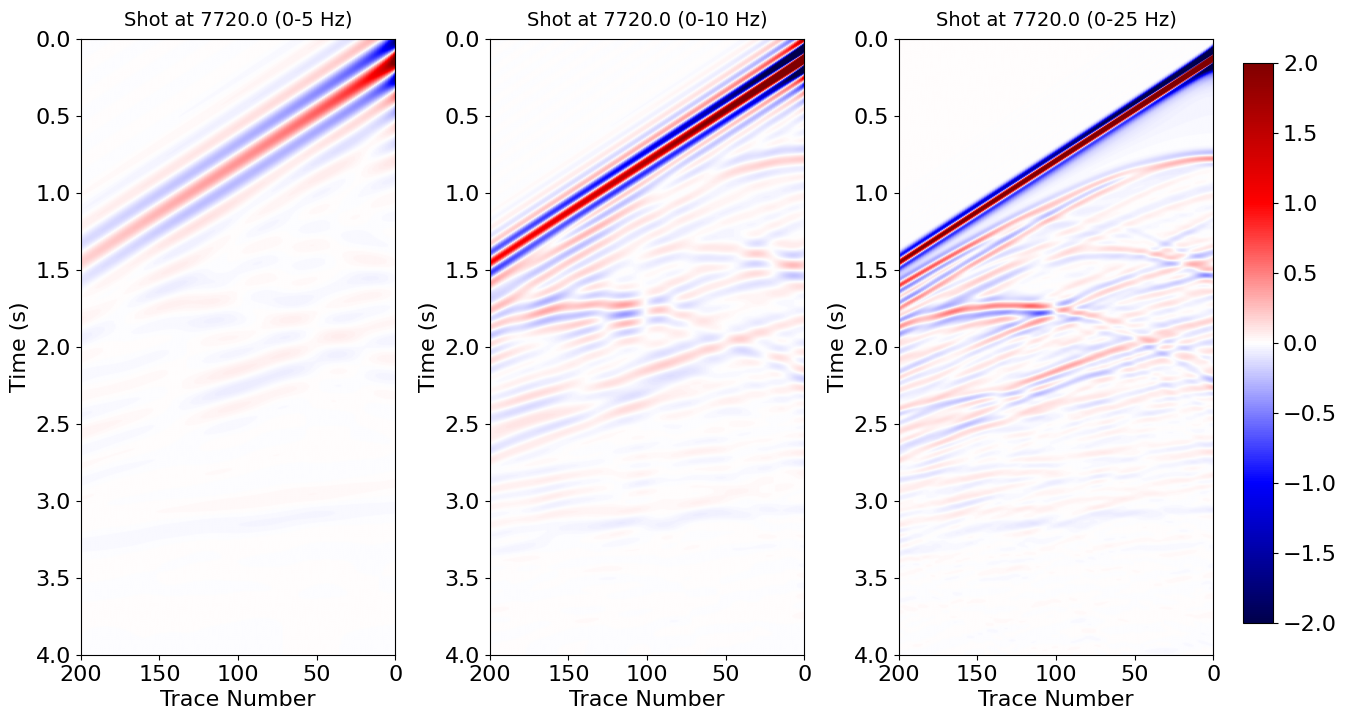

In [15]:
plot_shotrecord_cust(dobs1[19].data, f'Shot at {geometry1[19].src_positions[0][0].item()} (0-5 Hz)',
                     dobs2[19].data, f'Shot at {geometry1[19].src_positions[0][0].item()} (0-10 Hz)',
                     dobs3[19].data, f'Shot at {geometry1[19].src_positions[0][0].item()} (0-25 Hz)',
                     model=model1,
                     t0=geometry1[0].t0,
                     tn=geometry1[0].tn,
                     save=False,
                     colorbar=True)


In [16]:
# Make sure dt is match
assert geometry1[0].dt == model1.critical_dt == dt == par['dt']

In [17]:
# Run born fwi
# Create initial guess model for inversion by smoothing the true model

model_up = torch.tensor(model0.vp.data[nbl:-nbl, nbl:-nbl]).T
model_tr = torch.tensor(model1.vp.data[nbl:-nbl, nbl:-nbl]).T
scat = torch.zeros_like(model_up)

# Store to GPU
device = 'cuda'
model_up = model_up.clone().to(device)
model_tr = model_tr.clone().to(device)
model_up.requires_grad = True
model_tr.requires_grad = True
scat.requires_grad = True

msk = torch.ones_like(torch.Tensor(model_up))
msk[:50] = 0
#msk = msk.to(device)

depth = torch.tensor(list(range(0, 351))*1100).reshape(1100, 351).T /351
fwi_itr = 30
first_ep, eps = 50, 5

# Set up params
device = 'cuda'
network = UNet(n_channels=2, n_classes=1, hidden_channels=64).to(device)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
loss_mse = torch.nn.MSELoss()
loss_mae = torch.nn.L1Loss()

# Set up FWI loss function
def loss_fn_fwi(model_true, model_init, geoms, n_workers, clients, d_true, freq, nfilt):

    # Set initial and true model as devito object
    model_true = get_model(model_true.detach().cpu().numpy(), shape, spacing, origin)
    model_init = get_model(model_init.detach().cpu().numpy(), shape, spacing, origin)
    

    loss, grad = grad_multi_shots(model_true, model_init, geoms, n_workers, clients, d_true, freq, nfilt)    
    client.restart(wait_for_workers=False)
    
    return loss, torch.tensor(grad).T

def born_fn_fwi(model_true, model_back, model_scat, geoms, n_workers, client, freq, nfilt):

    # Set initial, true, and scat model as devito object
    model_true = get_model(model_true.detach().cpu().numpy(), shape, spacing, origin)
    model_back = get_model(model_back.detach().cpu().numpy(), shape, spacing, origin)
    
    _, dm1 = born_multi_shots(model_true, model_back, model_scat, geoms, n_workers, client, freq, nfilt)
    client.restart(wait_for_workers=False)
    
    return torch.tensor(dm1).T
    

### Scale 1 (0-5 Hz)

In [18]:
# Set up parameters
nbl = model1.nbl
geoms = geometry1.copy()
d_true = dobsfilt1.copy()
freq = 0.005
nfilt = 9

# Set up storage for scale 1
seis_loss1 = []
vp_mse1, vp_mae1, ssim1 = [], [], []
net_loss1 = []

fpath = 'model_progress/marm_born_trial/scale1'

strt = time.time()

# compute the first velocity difference after update model
mseloss = loss_mse(model_up, model_tr).item()
maeloss = loss_mae(model_up, model_tr).item()
ssimval = ssim(model_up.detach().cpu().numpy(), model_tr.detach().cpu().numpy(), data_range=model_up.detach().cpu().numpy().max() - model_up.detach().cpu().numpy().min())
vp_mse1.append(mseloss)
vp_mae1.append(maeloss)
ssim1.append(ssimval)

for itr in range(fwi_itr):
    
    # compute the FWI gradient and the data misfit
    loss, grad = loss_fn_fwi(model_tr.T, model_up.T, geoms, n_workers, client, d_true, freq, nfilt)
    print(f 'Iteration {itr+1}: data loss = {loss}')
    seis_loss1.append(loss)

    # Normalize by the maximum of the first gradient and mask the shallow part
    #if itr == 0:
    gmax = torch.abs(grad).max()
    grad *= msk.detach().cpu()
    grad /= torch.Tensor(gmax)
    
    # compute the remigrated image from the gradient
    scat_model = grad_utils(model1, geometry1[0])[0]
    scat_model.data[nbl:-nbl, nbl:-nbl] = grad.T
    dm1 = born_fn_fwi(model_tr.T, model_up.T, scat_model, geoms, n_workers, client, freq, nfilt)
    
    # Normalize by the maximum and mask the shallow part
    #if itr == 0:
    dm1max = torch.abs(dm1).max()
    dm1 *= msk.detach().cpu()
    dm1 /= dm1max

    # Create training data for the network to learn the inverse of the Hessian
    assert dm1.shape == depth.shape == grad.shape == msk.shape
    dataloader = prepare_data(torch.Tensor(dm1), depth, torch.Tensor((grad/1e1)), patch_size=64, slide=16, batch_size=64)
    
    # Train the network
    epochs = first_ep if itr == 0 else eps
    
    network.train()
    for ep in tqdm(range(epochs)):
        running_loss = 0
        for sample in dataloader:
            optimizer.zero_grad()
            
            x1, y1 = sample[0].to(device), sample[1].unsqueeze(1).to(device)
            dm_pred = network(x1)
            
            loss_ = loss_mse(dm_pred, y1)
            running_loss += loss_.item()
            
            loss_.backward()
            optimizer.step()
    
        net_loss1.append(running_loss/len(dataloader))

        print(f'Training Epoch {ep}, Loss = {running_loss/len(dataloader)}')

    # Apply the network to the FWI gradient to get the Hessian corrected update 
    dm1 = torch.Tensor(dm1).to(device)
    depth = depth.to(device)
    grad = torch.Tensor(grad).to(device)

    with torch.no_grad():
        inpg = torch.cat([dm1.unsqueeze(0), depth.unsqueeze(0)]).float().to(device)
        g = network(inpg.unsqueeze(0)).squeeze() * msk.to(device)
    
        inpdm = torch.cat([grad.unsqueeze(0), depth.unsqueeze(0)]).float().to(device)
        dm = network(inpdm.unsqueeze(0)).squeeze() * msk.to(device)
    
    # Update model
    if itr == 0:
        model_up = torch.clip((model_up-dm), minv, maxv)
    elif itr != 0 and vp_mse1[-1] <= vp_mse1[-2]:
        model_up = torch.clip((model_up-dm), minv, maxv)
    
    # compute the velocity difference after update model
    mseloss = loss_mse(model_up, model_tr).item()
    maeloss = loss_mae(model_up, model_tr).item()
    ssimval = ssim(model_up.detach().cpu().numpy(), model_tr.detach().cpu().numpy(), data_range=model_up.detach().cpu().numpy().max() - model_up.detach().cpu().numpy().min())
    print(f'Iteration {itr+1}: MSE loss = {mseloss}')
    print(f'Iteration {itr+1}: MAE loss = {maeloss}')
    print(f'Iteration {itr+1}: SSIM Value = {ssimval}')
    vp_mse1.append(mseloss)
    vp_mae1.append(maeloss)
    ssim1.append(ssimval)

    if itr == 0:
        np.savetxt(f'{fpath}/first_grad.txt', grad.detach().cpu().numpy())
        np.savetxt(f'{fpath}/first_dm1.txt', dm1.detach().cpu().numpy())
        np.savetxt(f'{fpath}/first_g.txt', g.detach().cpu().numpy())
        np.savetxt(f'{fpath}/first_dm.txt', dm.detach().cpu().numpy())
        np.savetxt(f'{fpath}/first_model.txt', model_up.detach().cpu().numpy())

    else:
        np.savetxt(f'{fpath}/grad_monitor.txt', grad.detach().cpu().numpy())
        np.savetxt(f'{fpath}/dm1_monitor.txt', dm1.detach().cpu().numpy())
        np.savetxt(f'{fpath}/g_monitor.txt', g.detach().cpu().numpy())
        np.savetxt(f'{fpath}/dm_monitor.txt', dm.detach().cpu().numpy())
        np.savetxt(f'{fpath}/model_monitor.txt', model_up.detach().cpu().numpy())
        np.savetxt(f'{fpath}/vp_mse_monitor.txt', vp_mse1)
        np.savetxt(f'{fpath}/vp_mae_monitor.txt', vp_mae1)
        np.savetxt(f'{fpath}/ssim_monitor.txt', ssim1)
        np.savetxt(f'{fpath}/seis_loss_monitor.txt', seis_loss1)
        np.savetxt(f'{fpath}/net_loss_monitor.txt', net_loss1)

    del dataloader
    gc.collect()
    torch.cuda.empty_cache()

model_up1 = model_up.clone().to(device)

fnsh = time.time()
dur = fnsh-strt

SyntaxError: invalid syntax (4057348496.py, line 29)

In [18]:
print(f'Running Duration for scale 1 (0-5Hz): {((dur)/3600):.2f} hrs')

Running Duration for scale 1 (0-5Hz): 2.30 hrs


### Scale 2 (0-10 Hz)

In [19]:
# Set up parameters
nbl = model1.nbl
geoms = geometry1.copy()
d_true = dobsfilt2.copy()
freq = 0.01
nfilt = 9

# Set up storage for scale 1
seis_loss2 = []
vp_mse2, vp_mae2, ssim2 = [], [], []
net_loss2  = []

fpath = 'model_progress/marm_born_trial/scale2'

strt = time.time()

# compute the first velocity difference after update model
mseloss = loss_mse(model_up, model_tr).item()
maeloss = loss_mae(model_up, model_tr).item()
ssimval = ssim(model_up.detach().cpu().numpy(), model_tr.detach().cpu().numpy(), data_range=model_up.detach().cpu().numpy().max() - model_up.detach().cpu().numpy().min())
vp_mse2.append(mseloss)
vp_mae2.append(maeloss)
ssim2.append(ssimval)

for itr in range(fwi_itr):
    
    # compute the FWI gradient and the data misfit
    loss, grad = loss_fn_fwi(model_tr.T, model_up.T, geoms, n_workers, client, d_true, freq, nfilt)
    print(f'Iteration {itr+1}: data loss = {loss}')
    seis_loss2.append(loss)

    # Normalize by the maximum of the first gradient and mask the shallow part
    #if itr == 0:
    gmax = torch.abs(grad).max()
    grad *= msk.detach().cpu()
    grad /= torch.Tensor(gmax)
    
    # compute the remigrated image from the gradient
    scat_model = grad_utils(model1, geometry1[0])[0]
    scat_model.data[nbl:-nbl, nbl:-nbl] = grad.T
    dm1 = born_fn_fwi(model_tr.T, model_up.T, scat_model, geoms, n_workers, client, freq, nfilt)
    
    # Normalize by the maximum and mask the shallow part
    #if itr == 0:
    dm1max = torch.abs(dm1).max()
    dm1 *= msk.detach().cpu()
    dm1 /= dm1max
    
    # Create training data for the network to learn the inverse of the Hessian
    assert dm1.shape == depth.shape == grad.shape == msk.shape
    dataloader = prepare_data(torch.Tensor(dm1), depth, torch.Tensor((grad/1e1)), patch_size=64, slide=16, batch_size=64)
    
    # Train the network
    epochs = first_ep if itr == 0 else eps
    
    network.train()
    for ep in tqdm(range(epochs)):
        running_loss = 0
        for sample in dataloader:
            optimizer.zero_grad()
            
            x1, y1 = sample[0].to(device), sample[1].unsqueeze(1).to(device)
            dm_pred = network(x1)
            
            loss_ = loss_mse(dm_pred, y1)
            running_loss += loss_.item()
            
            loss_.backward()
            optimizer.step()
    
        net_loss2.append(running_loss/len(dataloader))
    
        print(f'Training Epoch {ep}, Loss = {running_loss/len(dataloader)}')
    
    # Apply the network to the FWI gradient to get the Hessian corrected update 
    dm1 = torch.Tensor(dm1).to(device)
    depth = depth.to(device)
    grad = torch.Tensor(grad).to(device)

    with torch.no_grad():
        inpg = torch.cat([dm1.unsqueeze(0), depth.unsqueeze(0)]).float().to(device)
        g = network(inpg.unsqueeze(0)).squeeze() * msk.to(device)
    
        inpdm = torch.cat([grad.unsqueeze(0), depth.unsqueeze(0)]).float().to(device)
        dm = network(inpdm.unsqueeze(0)).squeeze() * msk.to(device)
    
    # Update model
    if itr == 0:
        model_up = torch.clip((model_up-dm), minv, maxv)
    elif itr != 0 and vp_mse1[-1] <= vp_mse1[-2]:
        model_up = torch.clip((model_up-dm), minv, maxv)
    
    # compute the velocity difference after update model
    mseloss = loss_mse(model_up, model_tr).item()
    maeloss = loss_mae(model_up, model_tr).item()
    ssimval = ssim(model_up.detach().cpu().numpy(), model_tr.detach().cpu().numpy(), data_range=model_up.detach().cpu().numpy().max() - model_up.detach().cpu().numpy().min())
    print(f'Iteration {itr+1}: MSE loss = {mseloss}')
    print(f'Iteration {itr+1}: MAE loss = {maeloss}')
    print(f'Iteration {itr+1}: SSIM Value = {ssimval}')
    vp_mse2.append(mseloss)
    vp_mae2.append(maeloss)
    ssim2.append(ssimval)

    if itr == 0:
        np.savetxt(f'{fpath}/first_grad.txt', grad.detach().cpu().numpy())
        np.savetxt(f'{fpath}/first_dm1.txt', dm1.detach().cpu().numpy())
        np.savetxt(f'{fpath}/first_g.txt', g.detach().cpu().numpy())
        np.savetxt(f'{fpath}/first_dm.txt', dm.detach().cpu().numpy())
        np.savetxt(f'{fpath}/first_model.txt', model_up.detach().cpu().numpy())

    else:
        np.savetxt(f'{fpath}/grad_monitor.txt', grad.detach().cpu().numpy())
        np.savetxt(f'{fpath}/dm1_monitor.txt', dm1.detach().cpu().numpy())
        np.savetxt(f'{fpath}/g_monitor.txt', g.detach().cpu().numpy())
        np.savetxt(f'{fpath}/dm_monitor.txt', dm.detach().cpu().numpy())
        np.savetxt(f'{fpath}/model_monitor.txt', model_up.detach().cpu().numpy())
        np.savetxt(f'{fpath}/vp_mse_monitor.txt', vp_mse2)
        np.savetxt(f'{fpath}/vp_mae_monitor.txt', vp_mae2)
        np.savetxt(f'{fpath}/ssim_monitor.txt', ssim2)
        np.savetxt(f'{fpath}/seis_loss_monitor.txt', seis_loss2)
        np.savetxt(f'{fpath}/net_loss_monitor.txt', net_loss2)
        
    del dataloader
    gc.collect()
    torch.cuda.empty_cache()

model_up2 = model_up.clone().to(device)

fnsh = time.time()
dur = fnsh-strt

/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 2.27 s
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.23 s
Operator `Forward` ran in 2.36 s
Operator `Forward` ran in 2.97 s
Operator `Gradient` ran in 2.87 s
Operator `Gradient` ran in 3.28 s
Operator `Gradient` ran in 3.21 s
Operator `Gradient` ran in 2.99 s
Operator `Gradient` ran in 3.00 s
Operator `Gradient` ran in 10.38 s
2025-08-06 17:46:19,782 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see htt

Iteration 1: data loss = 13980.7294921875


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.24 s
Operator `Forward` ran in 2.47 s
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.27 s
Operator `Forward` ran in 2.24 s
Operator `Forward` ran in 5.95 s
Operator `Born` ran in 3.82 s
Operator `Born` ran in 3.90 s
Operator `Born` ran in 4.00 s
Operator `Born` ran in 4.27 s
Operator `Born` ran in 4.21 s
Operator `Gradient` ran in 3.75 s
Operator `Born` ran in 4.53 s
Operator `Gradient` ran in 3.46 s
Operator `Gradient` ran in 3.41 s
Operator `Gradient` ran in 3.63 s
Operator `Gradient` ran in 5.94 s
Operator `Gradient` r

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.6542645733246864e-05
Training Epoch 1, Loss = 5.325886378801883e-06
Training Epoch 2, Loss = 3.586265090448701e-06
Training Epoch 3, Loss = 2.816646790607521e-06
Training Epoch 4, Loss = 2.2183135037881374e-06
Training Epoch 5, Loss = 1.9636583059385538e-06
Training Epoch 6, Loss = 1.7982213131963921e-06
Training Epoch 7, Loss = 1.78624107203323e-06
Training Epoch 8, Loss = 1.6481321754699416e-06
Training Epoch 9, Loss = 1.7122737616193057e-06
Training Epoch 10, Loss = 1.4424870974872606e-06
Training Epoch 11, Loss = 1.2301544578192665e-06
Training Epoch 12, Loss = 1.3955840717812474e-06
Training Epoch 13, Loss = 1.2302393347438678e-06
Training Epoch 14, Loss = 1.3233962684573562e-06
Training Epoch 15, Loss = 1.077478103329652e-06
Training Epoch 16, Loss = 1.1587436621261567e-06
Training Epoch 17, Loss = 1.1154941031188263e-06
Training Epoch 18, Loss = 1.1442617964202864e-06
Training Epoch 19, Loss = 1.028134151764022e-06
Training Epoch 20, Loss = 9.835385947

/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.04 s
Operator `Forward` ran in 2.23 s
Operator `Forward` ran in 2.08 s
Operator `Forward` ran in 2.30 s
Operator `Forward` ran in 2.45 s
Operator `Forward` ran in 2.19 s
Operator `Gradient` ran in 2.94 s
Operator `Gradient` ran in 2.97 s
Operator `Gradient` ran in 3.25 s
Operator `Gradient` ran in 3.37 s
Operator `Gradient` ran in 3.01 s
Operator `Gradient` ran in 3.82 s
2025-08-06 17:57:50,631 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 2: data loss = 8679.7373046875


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.34 s
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.21 s
Operator `Forward` ran in 2.35 s
Operator `Forward` ran in 2.40 s
Operator `Forward` ran in 2.37 s
Operator `Born` ran in 3.83 s
Operator `Born` ran in 3.94 s
Operator `Born` ran in 4.51 s
Operator `Born` ran in 4.72 s
Operator `Born` ran in 4.71 s
Operator `Born` ran in 4.92 s
Operator `Gradient` ran in 3.39 s
Operator `Gradient` ran in 3.39 s
Operator `Gradient` ran in 3.54 s
Operator `Gradient` ran in 3.62 s
Operator `Gradient` ran in 3.57 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.5168440994115273e-06
Training Epoch 1, Loss = 1.3840866221449786e-06
Training Epoch 2, Loss = 1.0398569159083356e-06
Training Epoch 3, Loss = 9.557816627734347e-07
Training Epoch 4, Loss = 9.144371319892533e-07
Iteration 2: MSE loss = 0.07356927543878555
Iteration 2: MAE loss = 0.16458554565906525
Iteration 2: SSIM Value = 0.6774407558351492


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 1.86 s
Operator `Forward` ran in 2.04 s
Operator `Forward` ran in 2.18 s
Operator `Gradient` ran in 2.92 s
Operator `Gradient` ran in 3.01 s
Operator `Gradient` ran in 2.98 s
Operator `Gradient` ran in 2.96 s
Operator `Forward` ran in 8.14 s
Operator `Forward` ran in 14.82 s
Operator `Gradient` ran in 6.11 s
Operator `Gradient` ran in 5.68 s
2025-08-06 18:02:13,610 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see htt

Iteration 3: data loss = 5712.22509765625


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.22 s
Operator `Forward` ran in 2.28 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.32 s
Operator `Forward` ran in 2.30 s
Operator `Forward` ran in 2.38 s
Operator `Born` ran in 3.95 s
Operator `Born` ran in 3.95 s
Operator `Born` ran in 4.67 s
Operator `Born` ran in 4.65 s
Operator `Born` ran in 4.65 s
Operator `Born` ran in 4.66 s
Operator `Gradient` ran in 3.32 s
Operator `Gradient` ran in 3.41 s
Operator `Gradient` ran in 3.49 s
Operator `Gradient` ran in 3.55 s
Operator `Gradient` ran in 3.75 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 3.463412083039576e-06
Training Epoch 1, Loss = 1.344809794875462e-06
Training Epoch 2, Loss = 1.2198284301807022e-06
Training Epoch 3, Loss = 8.886261041107146e-07
Training Epoch 4, Loss = 7.762799905927322e-07
Iteration 3: MSE loss = 0.07158306241035461
Iteration 3: MAE loss = 0.16162744164466858
Iteration 3: SSIM Value = 0.6831048028928484


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.12 s
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.41 s
Operator `Forward` ran in 2.21 s
Operator `Forward` ran in 2.20 s
Operator `Gradient` ran in 3.04 s
Operator `Gradient` ran in 3.29 s
Operator `Gradient` ran in 3.16 s
Operator `Gradient` ran in 3.10 s
Operator `Gradient` ran in 4.75 s
Operator `Forward` ran in 9.41 s
Operator `Gradient` ran in 4.80 s
2025-08-06 18:06:37,782 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 4: data loss = 4229.15625


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.26 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.35 s
Operator `Forward` ran in 2.36 s
Operator `Forward` ran in 2.14 s
Operator `Forward` ran in 2.38 s
Operator `Born` ran in 4.41 s
Operator `Born` ran in 3.90 s
Operator `Born` ran in 4.49 s
Operator `Born` ran in 4.14 s
Operator `Born` ran in 4.10 s
Operator `Born` ran in 4.32 s
Operator `Gradient` ran in 3.49 s
Operator `Gradient` ran in 3.51 s
Operator `Gradient` ran in 3.71 s
Operator `Gradient` ran in 4.63 s
Operator `Gradient` ran in 5.49 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.292453194100813e-06
Training Epoch 1, Loss = 1.0089086684153603e-06
Training Epoch 2, Loss = 8.953422093404992e-07
Training Epoch 3, Loss = 8.422632674282857e-07
Training Epoch 4, Loss = 7.690485620370324e-07
Iteration 4: MSE loss = 0.07028830796480179
Iteration 4: MAE loss = 0.15993383526802063
Iteration 4: SSIM Value = 0.6871004785565203


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 2.34 s
Operator `Forward` ran in 2.14 s
Operator `Forward` ran in 2.35 s
Operator `Forward` ran in 2.32 s
Operator `Gradient` ran in 3.01 s
Operator `Gradient` ran in 3.02 s
Operator `Gradient` ran in 3.00 s
Operator `Gradient` ran in 3.00 s
Operator `Gradient` ran in 3.67 s
Operator `Gradient` ran in 9.02 s
2025-08-06 18:10:45,075 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 5: data loss = 3449.140625


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.31 s
Operator `Forward` ran in 2.33 s
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.78 s
Operator `Born` ran in 3.98 s
Operator `Born` ran in 4.57 s
Operator `Born` ran in 3.98 s
Operator `Born` ran in 4.56 s
Operator `Gradient` ran in 3.41 s
Operator `Gradient` ran in 3.58 s
Operator `Gradient` ran in 3.55 s
Operator `Forward` ran in 12.98 s
Operator `Forward` ran in 13.79 s
Operator `Gradient` ran in 6.59 s
Operator `Born` ran in 3.91 s
Operator `Born` ran in 3.84 s
Operator `Gradient` ran in 5.63 s
Operator `Gradient`

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 7.394044917856471e-06
Training Epoch 1, Loss = 2.2489032693270933e-06
Training Epoch 2, Loss = 2.0383939878576943e-06
Training Epoch 3, Loss = 1.3905275699185956e-06
Training Epoch 4, Loss = 1.2200708452455915e-06
Iteration 5: MSE loss = 0.06807179749011993
Iteration 5: MAE loss = 0.15656410157680511
Iteration 5: SSIM Value = 0.6920788147681656


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.33 s
Operator `Forward` ran in 2.31 s
Operator `Forward` ran in 2.14 s
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.39 s
Operator `Forward` ran in 2.28 s
Operator `Gradient` ran in 2.97 s
Operator `Gradient` ran in 2.97 s
Operator `Gradient` ran in 3.18 s
Operator `Gradient` ran in 3.14 s
Operator `Gradient` ran in 3.26 s
Operator `Gradient` ran in 3.17 s
2025-08-06 18:15:04,161 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 6: data loss = 3078.208251953125


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.23 s
Operator `Born` ran in 3.95 s
Operator `Born` ran in 3.85 s
Operator `Born` ran in 4.03 s
Operator `Born` ran in 4.16 s
Operator `Born` ran in 4.09 s
Operator `Gradient` ran in 3.28 s
Operator `Gradient` ran in 3.42 s
Operator `Forward` ran in 10.92 s
Operator `Gradient` ran in 3.45 s
Operator `Gradient` ran in 3.36 s
Operator `Gradient` ran in 5.89 s
Operator `Born` ran in 3.87 s
Operator `Gradient` 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 6.1451115923264545e-06
Training Epoch 1, Loss = 1.9352456805908963e-06
Training Epoch 2, Loss = 1.6845496293870308e-06
Training Epoch 3, Loss = 1.2706996392779986e-06
Training Epoch 4, Loss = 1.2818395445856524e-06
Iteration 6: MSE loss = 0.067424476146698
Iteration 6: MAE loss = 0.15610305964946747
Iteration 6: SSIM Value = 0.6949671347374317


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.27 s
Operator `Forward` ran in 2.14 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.21 s
Operator `Forward` ran in 2.27 s
Operator `Forward` ran in 4.03 s
Operator `Gradient` ran in 2.99 s
Operator `Gradient` ran in 3.06 s
Operator `Gradient` ran in 3.03 s
Operator `Gradient` ran in 3.48 s
Operator `Gradient` ran in 2.93 s
Operator `Gradient` ran in 3.28 s
2025-08-06 18:19:32,664 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 7: data loss = 3531.928955078125


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.24 s
Operator `Forward` ran in 2.22 s
Operator `Forward` ran in 2.34 s
Operator `Forward` ran in 2.38 s
Operator `Forward` ran in 2.28 s
Operator `Born` ran in 3.96 s
Operator `Born` ran in 4.36 s
Operator `Born` ran in 4.16 s
Operator `Born` ran in 4.63 s
Operator `Born` ran in 4.74 s
Operator `Born` ran in 4.61 s
Operator `Gradient` ran in 3.61 s
Operator `Gradient` ran in 3.40 s
Operator `Gradient` ran in 3.36 s
Operator `Gradient` ran in 3.55 s
Operator `Gradient` ran in 5.59 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.4044251976461816e-05
Training Epoch 1, Loss = 6.490365741716083e-06
Training Epoch 2, Loss = 3.783938985927785e-06
Training Epoch 3, Loss = 2.6188293967305927e-06
Training Epoch 4, Loss = 2.130588994732658e-06
Iteration 7: MSE loss = 0.0662742555141449
Iteration 7: MAE loss = 0.15381871163845062
Iteration 7: SSIM Value = 0.694587086117959


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 2.35 s
Operator `Forward` ran in 2.12 s
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.37 s
Operator `Gradient` ran in 2.94 s
Operator `Gradient` ran in 3.18 s
Operator `Gradient` ran in 3.25 s
Operator `Gradient` ran in 2.98 s
Operator `Gradient` ran in 3.18 s
Operator `Forward` ran in 13.02 s
Operator `Gradient` ran in 5.45 s
2025-08-06 18:23:41,140 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see htt

Iteration 8: data loss = 9699.990234375


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.23 s
Operator `Forward` ran in 2.36 s
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.38 s
Operator `Forward` ran in 6.00 s
Operator `Born` ran in 3.92 s
Operator `Born` ran in 3.98 s
Operator `Born` ran in 4.22 s
Operator `Born` ran in 4.62 s
Operator `Born` ran in 4.37 s
Operator `Gradient` ran in 3.38 s
Operator `Gradient` ran in 3.40 s
Operator `Born` ran in 4.61 s
Operator `Gradient` ran in 3.37 s
Operator `Gradient` ran in 3.65 s
Operator `Gradient` ran in 5.60 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.5794030334024214e-05
Training Epoch 1, Loss = 4.487569655076735e-06
Training Epoch 2, Loss = 3.1467506443806915e-06
Training Epoch 3, Loss = 2.5268446503639125e-06
Training Epoch 4, Loss = 2.304883751544258e-06
Iteration 8: MSE loss = 0.06566603481769562
Iteration 8: MAE loss = 0.15373346209526062
Iteration 8: SSIM Value = 0.6998781592653


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.22 s
Operator `Forward` ran in 2.13 s
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.24 s
Operator `Forward` ran in 2.31 s
Operator `Gradient` ran in 3.02 s
Operator `Gradient` ran in 2.98 s
Operator `Gradient` ran in 3.09 s
Operator `Gradient` ran in 3.02 s
Operator `Gradient` ran in 3.18 s
Operator `Forward` ran in 6.69 s
Operator `Gradient` ran in 4.06 s
2025-08-06 18:27:50,045 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 9: data loss = 6488.36669921875


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.14 s
Operator `Forward` ran in 2.21 s
Operator `Forward` ran in 4.84 s
Operator `Born` ran in 3.91 s
Operator `Born` ran in 3.81 s
Operator `Born` ran in 3.96 s
Operator `Born` ran in 4.01 s
Operator `Born` ran in 3.97 s
Operator `Born` ran in 3.83 s
Operator `Gradient` ran in 3.25 s
Operator `Gradient` ran in 3.39 s
Operator `Gradient` ran in 3.32 s
Operator `Gradient` ran in 3.37 s
Operator `Gradient` ran in 5.64 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.1305491400489452e-05
Training Epoch 1, Loss = 3.886143319564186e-06
Training Epoch 2, Loss = 2.928481625121538e-06
Training Epoch 3, Loss = 2.0931264295506895e-06
Training Epoch 4, Loss = 1.7772096218304361e-06
Iteration 9: MSE loss = 0.06543407589197159
Iteration 9: MAE loss = 0.15247981250286102
Iteration 9: SSIM Value = 0.6987565259625003


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.29 s
Operator `Forward` ran in 1.96 s
Operator `Forward` ran in 2.28 s
Operator `Forward` ran in 2.14 s
Operator `Gradient` ran in 2.93 s
Operator `Gradient` ran in 2.99 s
Operator `Gradient` ran in 2.83 s
Operator `Gradient` ran in 3.19 s
Operator `Gradient` ran in 3.14 s
Operator `Gradient` ran in 3.03 s
2025-08-06 18:31:58,687 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 10: data loss = 3022.06982421875


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.33 s
Operator `Forward` ran in 2.37 s
Operator `Forward` ran in 2.25 s
Operator `Born` ran in 4.19 s
Operator `Born` ran in 4.01 s
Operator `Born` ran in 3.96 s
Operator `Born` ran in 4.53 s
Operator `Born` ran in 4.42 s
Operator `Gradient` ran in 3.34 s
Operator `Gradient` ran in 3.28 s
Operator `Gradient` ran in 3.40 s
Operator `Gradient` ran in 5.38 s
Operator `Forward` ran in 13.78 s
Operator `Gradient` ran in 10.97 s
Operator `Born` ran in 3.88 s
Operator `Gradient`

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 9.911468955749764e-06
Training Epoch 1, Loss = 5.1962572637632624e-06
Training Epoch 2, Loss = 3.48640046995756e-06
Training Epoch 3, Loss = 2.7425992896499712e-06
Training Epoch 4, Loss = 2.2528611741478145e-06
Iteration 10: MSE loss = 0.06494297087192535
Iteration 10: MAE loss = 0.15236595273017883
Iteration 10: SSIM Value = 0.701347302273891


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.14 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.37 s
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.02 s
Operator `Gradient` ran in 3.07 s
Operator `Gradient` ran in 2.99 s
Operator `Gradient` ran in 2.95 s
Operator `Gradient` ran in 2.99 s
Operator `Forward` ran in 7.58 s
Operator `Gradient` ran in 4.67 s
Operator `Gradient` ran in 3.93 s
2025-08-06 18:36:14,436 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 11: data loss = 3949.45361328125


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 2.10 s
Operator `Born` ran in 4.23 s
Operator `Born` ran in 3.93 s
Operator `Born` ran in 4.09 s
Operator `Born` ran in 4.48 s
Operator `Forward` ran in 8.93 s
Operator `Gradient` ran in 3.25 s
Operator `Gradient` ran in 3.39 s
Operator `Gradient` ran in 3.45 s
Operator `Forward` ran in 12.54 s
Operator `Born` ran in 3.89 s
Operator `Gradient` ran in 5.54 s
Operator `Born` ran in 3.86 s
Operator `Gradient` ran in 4.96 s
Operator `Gradient` 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 7.416972837345135e-06
Training Epoch 1, Loss = 2.3792250460631485e-06
Training Epoch 2, Loss = 2.014507578132286e-06
Training Epoch 3, Loss = 1.7652654810883717e-06
Training Epoch 4, Loss = 1.656168597921984e-06
Iteration 11: MSE loss = 0.06457741558551788
Iteration 11: MAE loss = 0.15119127929210663
Iteration 11: SSIM Value = 0.7003312216681581


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.30 s
Operator `Forward` ran in 2.38 s
Operator `Forward` ran in 2.31 s
Operator `Forward` ran in 2.37 s
Operator `Gradient` ran in 2.98 s
Operator `Gradient` ran in 2.99 s
Operator `Gradient` ran in 3.17 s
Operator `Gradient` ran in 3.20 s
Operator `Gradient` ran in 3.17 s
Operator `Gradient` ran in 3.25 s
2025-08-06 18:40:25,722 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 12: data loss = 3666.685791015625


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.36 s
Operator `Forward` ran in 2.31 s
Operator `Forward` ran in 2.51 s
Operator `Forward` ran in 2.38 s
Operator `Born` ran in 3.84 s
Operator `Born` ran in 4.01 s
Operator `Born` ran in 3.98 s
Operator `Born` ran in 4.50 s
Operator `Born` ran in 4.38 s
Operator `Born` ran in 4.57 s
Operator `Gradient` ran in 3.39 s
Operator `Gradient` ran in 3.47 s
Operator `Gradient` ran in 3.36 s
Operator `Gradient` ran in 4.69 s
Operator `Gradient` ran in 4.96 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 8.701526575251397e-06
Training Epoch 1, Loss = 2.6199154932645e-06
Training Epoch 2, Loss = 2.0847289208236222e-06
Training Epoch 3, Loss = 1.6409196531711585e-06
Training Epoch 4, Loss = 1.5188177624765556e-06
Iteration 12: MSE loss = 0.06438346207141876
Iteration 12: MAE loss = 0.15163743495941162
Iteration 12: SSIM Value = 0.7026241970822833


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.22 s
Operator `Forward` ran in 2.35 s
Operator `Forward` ran in 2.07 s
Operator `Forward` ran in 2.66 s
Operator `Forward` ran in 2.25 s
Operator `Gradient` ran in 3.02 s
Operator `Gradient` ran in 2.92 s
Operator `Gradient` ran in 3.17 s
Operator `Gradient` ran in 3.19 s
Operator `Gradient` ran in 3.35 s
Operator `Gradient` ran in 3.81 s
2025-08-06 18:44:30,891 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 13: data loss = 5880.1044921875


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 5.90 s
Operator `Born` ran in 4.10 s
Operator `Born` ran in 4.09 s
Operator `Born` ran in 3.94 s
Operator `Forward` ran in 11.42 s
Operator `Forward` ran in 12.37 s
Operator `Gradient` ran in 5.11 s
Operator `Forward` ran in 14.02 s
Operator `Born` ran in 3.89 s
Operator `Born` ran in 3.89 s
Operator `Born` ran in 3.88 s
Operator `Gradient` ran in 11.41 s
Operator `Gradient` ran in 8.73 s
Operator `Gradient` ran in 5.95 s
Operator `Gradient` ran in 5.61 s
Operator `Gradien

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 7.096591116040784e-06
Training Epoch 1, Loss = 2.7572235523881947e-06
Training Epoch 2, Loss = 2.0920196493845014e-06
Training Epoch 3, Loss = 1.7269226080691596e-06
Training Epoch 4, Loss = 1.3820877811341814e-06
Iteration 13: MSE loss = 0.06435033679008484
Iteration 13: MAE loss = 0.15083430707454681
Iteration 13: SSIM Value = 0.7017050106766206


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.22 s
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.10 s
Operator `Forward` ran in 2.37 s
Operator `Forward` ran in 2.36 s
Operator `Forward` ran in 2.05 s
Operator `Gradient` ran in 2.98 s
Operator `Gradient` ran in 2.99 s
Operator `Gradient` ran in 3.02 s
Operator `Gradient` ran in 3.24 s
Operator `Gradient` ran in 2.95 s
Operator `Gradient` ran in 4.36 s
2025-08-06 18:48:42,412 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 14: data loss = 1880.6158447265625


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.27 s
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.23 s
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.37 s
Operator `Born` ran in 3.98 s
Operator `Born` ran in 4.48 s
Operator `Born` ran in 4.45 s
Operator `Born` ran in 4.74 s
Operator `Born` ran in 4.70 s
Operator `Gradient` ran in 3.33 s
Operator `Gradient` ran in 3.32 s
Operator `Gradient` ran in 3.64 s
Operator `Gradient` ran in 3.70 s
Operator `Forward` ran in 14.80 s
Operator `Born` ran in 3.97 s
Operator `Gradient` ran in 12.20 s
Operator `Gradient`

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 3.0021495482324968e-06
Training Epoch 1, Loss = 1.4479974228497387e-06
Training Epoch 2, Loss = 1.168905876149792e-06
Training Epoch 3, Loss = 1.11656197939694e-06
Training Epoch 4, Loss = 9.583072017110668e-07
Iteration 14: MSE loss = 0.06412670016288757
Iteration 14: MAE loss = 0.15046480298042297
Iteration 14: SSIM Value = 0.7024598240475671


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.11 s
Operator `Forward` ran in 2.14 s
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.44 s
Operator `Forward` ran in 2.47 s
Operator `Forward` ran in 2.04 s
Operator `Gradient` ran in 2.97 s
Operator `Gradient` ran in 2.93 s
Operator `Gradient` ran in 2.97 s
Operator `Gradient` ran in 3.03 s
Operator `Gradient` ran in 4.53 s
Operator `Gradient` ran in 6.76 s
2025-08-06 18:53:03,854 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 15: data loss = 1478.1446533203125


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.21 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.08 s
Operator `Forward` ran in 5.87 s
Operator `Born` ran in 3.89 s
Operator `Born` ran in 3.84 s
Operator `Born` ran in 3.92 s
Operator `Born` ran in 3.87 s
Operator `Gradient` ran in 3.39 s
Operator `Born` ran in 3.98 s
Operator `Gradient` ran in 3.24 s
Operator `Gradient` ran in 3.51 s
Operator `Gradient` ran in 3.27 s
Operator `Forward` ran in 11.98 s
Operator `Gradient` ran in 5.17 s
Operator `Born` ran in 3.92 s
Operator `Gradient` 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.9013573217202029e-06
Training Epoch 1, Loss = 1.4025465658771108e-06
Training Epoch 2, Loss = 1.2042889236012026e-06
Training Epoch 3, Loss = 1.1124598474961865e-06
Training Epoch 4, Loss = 1.0422704133633156e-06
Iteration 15: MSE loss = 0.06365622580051422
Iteration 15: MAE loss = 0.1497698724269867
Iteration 15: SSIM Value = 0.7032276516261251


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.27 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.34 s
Operator `Forward` ran in 2.01 s
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.48 s
Operator `Gradient` ran in 2.99 s
Operator `Gradient` ran in 2.97 s
Operator `Gradient` ran in 3.04 s
Operator `Gradient` ran in 2.98 s
Operator `Gradient` ran in 3.38 s
Operator `Gradient` ran in 9.68 s
2025-08-06 18:57:33,438 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 16: data loss = 1449.3270263671875


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.36 s
Operator `Forward` ran in 2.21 s
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.36 s
Operator `Forward` ran in 2.40 s
Operator `Forward` ran in 2.36 s
Operator `Born` ran in 4.02 s
Operator `Born` ran in 3.90 s
Operator `Born` ran in 4.05 s
Operator `Born` ran in 4.41 s
Operator `Born` ran in 4.48 s
Operator `Born` ran in 4.38 s
Operator `Gradient` ran in 3.53 s
Operator `Gradient` ran in 3.52 s
Operator `Gradient` ran in 3.52 s
Operator `Gradient` ran in 3.43 s
Operator `Gradient` ran in 3.51 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 9.726274887377938e-07
Training Epoch 1, Loss = 7.430065496649215e-07
Training Epoch 2, Loss = 6.663613551006968e-07
Training Epoch 3, Loss = 6.358630486826393e-07
Training Epoch 4, Loss = 6.265868485666763e-07
Iteration 16: MSE loss = 0.06320305168628693
Iteration 16: MAE loss = 0.1490597426891327
Iteration 16: SSIM Value = 0.7040828989576846


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 2.38 s
Operator `Forward` ran in 2.38 s
Operator `Forward` ran in 2.34 s
Operator `Forward` ran in 2.36 s
Operator `Gradient` ran in 2.98 s
Operator `Gradient` ran in 3.01 s
Operator `Gradient` ran in 3.18 s
Operator `Gradient` ran in 3.25 s
Operator `Gradient` ran in 3.24 s
Operator `Gradient` ran in 3.34 s
2025-08-06 19:01:39,806 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 17: data loss = 1336.3472900390625


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.14 s
Operator `Born` ran in 4.20 s
Operator `Born` ran in 3.83 s
Operator `Born` ran in 3.83 s
Operator `Born` ran in 4.57 s
Operator `Born` ran in 4.08 s
Operator `Forward` ran in 9.19 s
Operator `Gradient` ran in 3.36 s
Operator `Gradient` ran in 3.84 s
Operator `Gradient` ran in 3.33 s
Operator `Gradient` ran in 3.42 s
Operator `Born` ran in 3.90 s
Operator `Gradient` ran in 5.75 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.0548329222303822e-06
Training Epoch 1, Loss = 7.204047801562423e-07
Training Epoch 2, Loss = 6.340091863266345e-07
Training Epoch 3, Loss = 5.869299858901479e-07
Training Epoch 4, Loss = 5.9572760195924e-07
Iteration 17: MSE loss = 0.06293552368879318
Iteration 17: MAE loss = 0.14864875376224518
Iteration 17: SSIM Value = 0.7046162311614842


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.14 s
Operator `Forward` ran in 2.32 s
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.34 s
Operator `Gradient` ran in 2.95 s
Operator `Gradient` ran in 2.99 s
Operator `Gradient` ran in 3.01 s
Operator `Gradient` ran in 3.96 s
Operator `Forward` ran in 8.68 s
Operator `Forward` ran in 10.41 s
Operator `Gradient` ran in 5.29 s
Operator `Gradient` ran in 5.28 s
2025-08-06 19:06:07,512 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see htt

Iteration 18: data loss = 1237.3580322265625


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.37 s
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.41 s
Operator `Forward` ran in 2.39 s
Operator `Forward` ran in 2.42 s
Operator `Born` ran in 4.20 s
Operator `Born` ran in 4.18 s
Operator `Born` ran in 3.89 s
Operator `Born` ran in 4.60 s
Operator `Born` ran in 4.61 s
Operator `Born` ran in 4.74 s
Operator `Gradient` ran in 3.41 s
Operator `Gradient` ran in 3.64 s
Operator `Gradient` ran in 3.34 s
Operator `Gradient` ran in 3.65 s
Operator `Gradient` ran in 5.73 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 8.190440551977032e-07
Training Epoch 1, Loss = 6.328596291596951e-07
Training Epoch 2, Loss = 5.275680093559661e-07
Training Epoch 3, Loss = 5.368565332415411e-07
Training Epoch 4, Loss = 5.079722314864332e-07
Iteration 18: MSE loss = 0.0625692754983902
Iteration 18: MAE loss = 0.14805901050567627
Iteration 18: SSIM Value = 0.7052582053898481


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.34 s
Operator `Forward` ran in 1.99 s
Operator `Forward` ran in 2.34 s
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.04 s
Operator `Forward` ran in 2.12 s
Operator `Gradient` ran in 2.85 s
Operator `Gradient` ran in 3.14 s
Operator `Gradient` ran in 2.99 s
Operator `Gradient` ran in 3.00 s
Operator `Gradient` ran in 3.11 s
Operator `Gradient` ran in 4.09 s
2025-08-06 19:10:22,592 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 19: data loss = 1142.2891845703125


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.25 s
Operator `Forward` ran in 2.33 s
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.33 s
Operator `Forward` ran in 2.33 s
Operator `Forward` ran in 4.96 s
Operator `Born` ran in 3.93 s
Operator `Born` ran in 4.44 s
Operator `Born` ran in 3.95 s
Operator `Born` ran in 4.41 s
Operator `Born` ran in 4.44 s
Operator `Born` ran in 4.20 s
Operator `Gradient` ran in 3.35 s
Operator `Gradient` ran in 3.47 s
Operator `Gradient` ran in 3.57 s
Operator `Gradient` ran in 5.59 s
Operator `Gradient` ran in 6.78 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 8.431557135665117e-07
Training Epoch 1, Loss = 7.22737240818474e-07
Training Epoch 2, Loss = 6.290335451973364e-07
Training Epoch 3, Loss = 5.855145039574968e-07
Training Epoch 4, Loss = 5.864269183351474e-07
Iteration 19: MSE loss = 0.062170371413230896
Iteration 19: MAE loss = 0.14743947982788086
Iteration 19: SSIM Value = 0.7060357150512343


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.14 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.13 s
Operator `Gradient` ran in 2.94 s
Operator `Gradient` ran in 2.95 s
Operator `Gradient` ran in 2.96 s
Operator `Gradient` ran in 2.94 s
Operator `Forward` ran in 9.76 s
Operator `Forward` ran in 14.36 s
Operator `Gradient` ran in 4.30 s
Operator `Gradient` ran in 5.99 s
2025-08-06 19:14:47,240 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see htt

Iteration 20: data loss = 1151.0828857421875


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.32 s
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.30 s
Operator `Forward` ran in 2.47 s
Operator `Forward` ran in 2.33 s
Operator `Forward` ran in 2.35 s
Operator `Born` ran in 4.01 s
Operator `Born` ran in 4.03 s
Operator `Born` ran in 4.72 s
Operator `Born` ran in 4.70 s
Operator `Born` ran in 4.71 s
Operator `Born` ran in 4.70 s
Operator `Gradient` ran in 3.44 s
Operator `Gradient` ran in 3.30 s
Operator `Gradient` ran in 3.61 s
Operator `Gradient` ran in 3.70 s
Operator `Gradient` ran in 5.62 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 6.176621577736893e-07
Training Epoch 1, Loss = 5.25100436931228e-07
Training Epoch 2, Loss = 4.2281101830003193e-07
Training Epoch 3, Loss = 4.6653787995224844e-07
Training Epoch 4, Loss = 4.3642694019019703e-07
Iteration 20: MSE loss = 0.062003154307603836
Iteration 20: MAE loss = 0.14709773659706116
Iteration 20: SSIM Value = 0.7064870038914335


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.14 s
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.37 s
Operator `Forward` ran in 2.36 s
Operator `Gradient` ran in 2.91 s
Operator `Gradient` ran in 3.01 s
Operator `Gradient` ran in 2.98 s
Operator `Gradient` ran in 3.22 s
Operator `Gradient` ran in 3.18 s
Operator `Forward` ran in 11.14 s
Operator `Gradient` ran in 7.18 s
2025-08-06 19:19:05,813 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see htt

Iteration 21: data loss = 1027.87646484375


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.34 s
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.25 s
Operator `Forward` ran in 2.36 s
Operator `Forward` ran in 2.35 s
Operator `Forward` ran in 2.34 s
Operator `Born` ran in 3.91 s
Operator `Born` ran in 4.10 s
Operator `Born` ran in 4.09 s
Operator `Born` ran in 3.91 s
Operator `Born` ran in 3.97 s
Operator `Born` ran in 4.51 s
Operator `Gradient` ran in 3.42 s
Operator `Gradient` ran in 3.31 s
Operator `Gradient` ran in 5.88 s
Operator `Gradient` ran in 5.28 s
Operator `Gradient` ran in 7.82 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 7.895078321800779e-07
Training Epoch 1, Loss = 6.359838042808033e-07
Training Epoch 2, Loss = 5.542063900919463e-07
Training Epoch 3, Loss = 5.403842298018927e-07
Training Epoch 4, Loss = 5.864683017991144e-07
Iteration 21: MSE loss = 0.06168261542916298
Iteration 21: MAE loss = 0.14653410017490387
Iteration 21: SSIM Value = 0.706950796739574


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.33 s
Operator `Forward` ran in 2.14 s
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.35 s
Operator `Gradient` ran in 2.94 s
Operator `Gradient` ran in 3.14 s
Operator `Gradient` ran in 2.99 s
Operator `Gradient` ran in 3.03 s
Operator `Gradient` ran in 3.26 s
Operator `Forward` ran in 13.99 s
Operator `Gradient` ran in 5.96 s
2025-08-06 19:23:43,305 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see htt

Iteration 22: data loss = 1105.9456787109375


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.28 s
Operator `Forward` ran in 2.36 s
Operator `Forward` ran in 2.36 s
Operator `Forward` ran in 2.40 s
Operator `Born` ran in 4.01 s
Operator `Born` ran in 4.53 s
Operator `Born` ran in 4.57 s
Operator `Born` ran in 4.67 s
Operator `Born` ran in 4.73 s
Operator `Forward` ran in 10.99 s
Operator `Gradient` ran in 3.72 s
Operator `Gradient` ran in 3.54 s
Operator `Gradient` ran in 3.37 s
Operator `Gradient` ran in 3.66 s
Operator `Gradient` ran in 3.69 s
Operator `Born` ran in 3.89 s
Operator `Gradient` 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.435107363473646e-07
Training Epoch 1, Loss = 3.8987374605328173e-07
Training Epoch 2, Loss = 3.410988411980489e-07
Training Epoch 3, Loss = 3.26319868958643e-07
Training Epoch 4, Loss = 3.453203035373933e-07
Iteration 22: MSE loss = 0.0615079291164875
Iteration 22: MAE loss = 0.14619961380958557
Iteration 22: SSIM Value = 0.7074502855499852


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 1.98 s
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.32 s
Operator `Forward` ran in 2.08 s
Operator `Forward` ran in 2.27 s
Operator `Gradient` ran in 3.00 s
Operator `Gradient` ran in 2.92 s
Operator `Gradient` ran in 3.22 s
Operator `Gradient` ran in 3.16 s
Operator `Gradient` ran in 3.18 s
Operator `Gradient` ran in 2.98 s
2025-08-06 19:28:19,444 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 23: data loss = 956.2059936523438


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.32 s
Operator `Forward` ran in 2.37 s
Operator `Forward` ran in 2.39 s
Operator `Forward` ran in 2.22 s
Operator `Forward` ran in 2.13 s
Operator `Forward` ran in 2.30 s
Operator `Born` ran in 3.86 s
Operator `Born` ran in 3.86 s
Operator `Born` ran in 4.34 s
Operator `Born` ran in 4.64 s
Operator `Born` ran in 4.84 s
Operator `Born` ran in 4.51 s
Operator `Gradient` ran in 3.68 s
Operator `Gradient` ran in 3.40 s
Operator `Gradient` ran in 3.40 s
Operator `Gradient` ran in 3.53 s
Operator `Gradient` ran in 3.44 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 5.283026973524126e-07
Training Epoch 1, Loss = 4.246685633044589e-07
Training Epoch 2, Loss = 4.233119881776726e-07
Training Epoch 3, Loss = 3.989984622895764e-07
Training Epoch 4, Loss = 3.811095741879858e-07
Iteration 23: MSE loss = 0.06127471104264259
Iteration 23: MAE loss = 0.14578187465667725
Iteration 23: SSIM Value = 0.7079215917115493


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.37 s
Operator `Forward` ran in 2.40 s
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.07 s
Operator `Forward` ran in 2.16 s
Operator `Gradient` ran in 3.19 s
Operator `Gradient` ran in 2.95 s
Operator `Gradient` ran in 3.76 s
Operator `Gradient` ran in 2.94 s
Operator `Gradient` ran in 2.95 s
Operator `Gradient` ran in 3.16 s
2025-08-06 19:32:20,881 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 24: data loss = 954.0697021484375


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.34 s
Operator `Forward` ran in 2.30 s
Operator `Forward` ran in 2.44 s
Operator `Forward` ran in 2.15 s
Operator `Born` ran in 3.91 s
Operator `Born` ran in 3.87 s
Operator `Born` ran in 4.29 s
Operator `Born` ran in 4.05 s
Operator `Born` ran in 4.26 s
Operator `Gradient` ran in 3.37 s
Operator `Gradient` ran in 3.79 s
Operator `Gradient` ran in 3.18 s
Operator `Forward` ran in 12.00 s
Operator `Gradient` ran in 5.59 s
Operator `Gradient` ran in 5.71 s
Operator `Born` ran in 3.98 s
Operator `Gradient` 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.977486248243849e-07
Training Epoch 1, Loss = 4.335343098001453e-07
Training Epoch 2, Loss = 3.7438623718518995e-07
Training Epoch 3, Loss = 3.973467688878832e-07
Training Epoch 4, Loss = 3.8220373453317263e-07
Iteration 24: MSE loss = 0.06103280559182167
Iteration 24: MAE loss = 0.14535319805145264
Iteration 24: SSIM Value = 0.7082535678018796


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.21 s
Operator `Forward` ran in 2.64 s
Operator `Forward` ran in 2.16 s
Operator `Gradient` ran in 2.97 s
Operator `Gradient` ran in 2.98 s
Operator `Forward` ran in 6.97 s
Operator `Gradient` ran in 4.91 s
Operator `Forward` ran in 12.43 s
Operator `Forward` ran in 13.48 s
Operator `Gradient` ran in 5.02 s
Operator `Gradient` ran in 5.44 s
Operator `Gradient` ran in 5.67 s
2025-08-06 19:36:36,470 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see ht

Iteration 25: data loss = 974.4671020507812


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.23 s
Operator `Forward` ran in 2.25 s
Operator `Forward` ran in 2.21 s
Operator `Forward` ran in 2.23 s
Operator `Born` ran in 3.97 s
Operator `Born` ran in 3.96 s
Operator `Born` ran in 4.03 s
Operator `Born` ran in 3.89 s
Operator `Forward` ran in 7.39 s
Operator `Forward` ran in 7.70 s
Operator `Gradient` ran in 3.59 s
Operator `Gradient` ran in 3.47 s
Operator `Born` ran in 3.96 s
Operator `Gradient` ran in 4.88 s
Operator `Gradient` ran in 5.25 s
Operator `Born` ran in 4.13 s
Operator `Gradient` ran in 5.63 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.069292490563608e-07
Training Epoch 1, Loss = 3.344595439889588e-07
Training Epoch 2, Loss = 3.2383809634945614e-07
Training Epoch 3, Loss = 3.2334512839555047e-07
Training Epoch 4, Loss = 2.9407982877540706e-07
Iteration 25: MSE loss = 0.060893915593624115
Iteration 25: MAE loss = 0.1450888216495514
Iteration 25: SSIM Value = 0.708658831774096


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 2.14 s
Operator `Forward` ran in 2.02 s
Operator `Forward` ran in 2.11 s
Operator `Forward` ran in 2.14 s
Operator `Forward` ran in 2.25 s
Operator `Gradient` ran in 2.89 s
Operator `Gradient` ran in 3.15 s
Operator `Gradient` ran in 3.04 s
Operator `Gradient` ran in 3.14 s
Operator `Gradient` ran in 3.02 s
Operator `Gradient` ran in 4.56 s
2025-08-06 19:40:55,170 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 26: data loss = 875.9119873046875


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.33 s
Operator `Forward` ran in 2.36 s
Operator `Born` ran in 3.87 s
Operator `Born` ran in 4.15 s
Operator `Born` ran in 4.48 s
Operator `Born` ran in 4.57 s
Operator `Forward` ran in 10.78 s
Operator `Forward` ran in 11.42 s
Operator `Gradient` ran in 3.35 s
Operator `Gradient` ran in 4.49 s
Operator `Gradient` ran in 6.52 s
Operator `Born` ran in 3.84 s
Operator `Born` ran in 3.84 s
Operator `Gradient` ran in 11.81 s
Operator `Gradient` ran in 5.79 s
Operator `Gradient

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 5.43150700152381e-07
Training Epoch 1, Loss = 4.512937055864959e-07
Training Epoch 2, Loss = 3.8718432938211984e-07
Training Epoch 3, Loss = 3.8941456646776286e-07
Training Epoch 4, Loss = 3.713517471076979e-07
Iteration 26: MSE loss = 0.06062469631433487
Iteration 26: MAE loss = 0.144636869430542
Iteration 26: SSIM Value = 0.708948962871342


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.37 s
Operator `Forward` ran in 2.11 s
Operator `Forward` ran in 2.38 s
Operator `Forward` ran in 2.25 s
Operator `Forward` ran in 2.15 s
Operator `Gradient` ran in 2.94 s
Operator `Gradient` ran in 2.98 s
Operator `Gradient` ran in 2.98 s
Operator `Gradient` ran in 3.24 s
Operator `Gradient` ran in 2.92 s
Operator `Gradient` ran in 5.39 s
2025-08-06 19:45:08,569 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 27: data loss = 945.72265625


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.34 s
Operator `Forward` ran in 4.42 s
Operator `Born` ran in 3.94 s
Operator `Born` ran in 3.96 s
Operator `Born` ran in 4.26 s
Operator `Born` ran in 4.07 s
Operator `Born` ran in 4.12 s
Operator `Born` ran in 4.21 s
Operator `Gradient` ran in 3.36 s
Operator `Gradient` ran in 3.42 s
Operator `Gradient` ran in 3.39 s
Operator `Gradient` ran in 5.78 s
Operator `Gradient` ran in 5.45 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 5.499769095809614e-07
Training Epoch 1, Loss = 3.595418571346486e-07
Training Epoch 2, Loss = 3.7209579089067307e-07
Training Epoch 3, Loss = 3.540296090871786e-07
Training Epoch 4, Loss = 3.4458576977479644e-07
Iteration 27: MSE loss = 0.06051509827375412
Iteration 27: MAE loss = 0.14442649483680725
Iteration 27: SSIM Value = 0.7092832031968584


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.30 s
Operator `Forward` ran in 2.14 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.08 s
Operator `Forward` ran in 2.42 s
Operator `Forward` ran in 4.02 s
Operator `Gradient` ran in 2.99 s
Operator `Gradient` ran in 3.02 s
Operator `Gradient` ran in 2.98 s
Operator `Gradient` ran in 3.09 s
Operator `Gradient` ran in 3.42 s
Operator `Gradient` ran in 4.10 s
2025-08-06 19:49:25,265 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 28: data loss = 887.776123046875


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.21 s
Operator `Forward` ran in 2.30 s
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.62 s
Operator `Forward` ran in 2.33 s
Operator `Born` ran in 3.94 s
Operator `Born` ran in 4.56 s
Operator `Born` ran in 3.92 s
Operator `Born` ran in 4.26 s
Operator `Born` ran in 4.56 s
Operator `Born` ran in 4.57 s
Operator `Gradient` ran in 3.43 s
Operator `Gradient` ran in 3.40 s
Operator `Gradient` ran in 3.50 s
Operator `Gradient` ran in 5.56 s
Operator `Gradient` ran in 5.89 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 5.583278423529527e-07
Training Epoch 1, Loss = 3.783080400812759e-07
Training Epoch 2, Loss = 4.144122815708125e-07
Training Epoch 3, Loss = 3.3833409715115067e-07
Training Epoch 4, Loss = 3.576453360238444e-07
Iteration 28: MSE loss = 0.060349419713020325
Iteration 28: MAE loss = 0.14409644901752472
Iteration 28: SSIM Value = 0.709527113920843


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.25 s
Operator `Forward` ran in 2.10 s
Operator `Forward` ran in 2.06 s
Operator `Forward` ran in 2.13 s
Operator `Gradient` ran in 3.01 s
Operator `Gradient` ran in 2.85 s
Operator `Gradient` ran in 3.05 s
Operator `Gradient` ran in 3.10 s
Operator `Forward` ran in 8.52 s
Operator `Forward` ran in 9.76 s
Operator `Gradient` ran in 5.08 s
Operator `Gradient` ran in 4.95 s
2025-08-06 19:53:48,775 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 29: data loss = 891.0374145507812


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.29 s
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.28 s
Operator `Forward` ran in 2.35 s
Operator `Forward` ran in 2.56 s
Operator `Born` ran in 3.96 s
Operator `Born` ran in 3.90 s
Operator `Born` ran in 3.87 s
Operator `Born` ran in 4.81 s
Operator `Born` ran in 4.13 s
Operator `Born` ran in 4.22 s
Operator `Gradient` ran in 3.33 s
Operator `Gradient` ran in 3.38 s
Operator `Gradient` ran in 3.36 s
Operator `Gradient` ran in 3.34 s
Operator `Gradient` ran in 6.20 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 3.4223639252081193e-07
Training Epoch 1, Loss = 3.2656965426749995e-07
Training Epoch 2, Loss = 2.959796267007534e-07
Training Epoch 3, Loss = 2.774557852426788e-07
Training Epoch 4, Loss = 2.869513751770512e-07
Iteration 29: MSE loss = 0.06018633022904396
Iteration 29: MAE loss = 0.14379426836967468
Iteration 29: SSIM Value = 0.7098670530194208


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 2.36 s
Operator `Forward` ran in 2.34 s
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 2.07 s
Operator `Gradient` ran in 3.01 s
Operator `Gradient` ran in 2.97 s
Operator `Gradient` ran in 3.00 s
Operator `Gradient` ran in 3.05 s
Operator `Forward` ran in 6.80 s
Operator `Gradient` ran in 6.28 s
Operator `Gradient` ran in 4.28 s
2025-08-06 19:58:26,527 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 30: data loss = 818.8805541992188


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.35 s
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.38 s
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.16 s
Operator `Born` ran in 3.94 s
Operator `Born` ran in 3.92 s
Operator `Born` ran in 4.02 s
Operator `Born` ran in 3.95 s
Operator `Forward` ran in 7.47 s
Operator `Born` ran in 4.07 s
Operator `Gradient` ran in 3.28 s
Operator `Gradient` ran in 3.35 s
Operator `Gradient` ran in 3.43 s
Operator `Gradient` ran in 3.34 s
Operator `Born` ran in 4.05 s
Operator `Gradient` ran in 5.52 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 3.6433083839625525e-07
Training Epoch 1, Loss = 3.6579559353330805e-07
Training Epoch 2, Loss = 3.469374500602666e-07
Training Epoch 3, Loss = 3.0486734320208004e-07
Training Epoch 4, Loss = 3.071697769588143e-07
Iteration 30: MSE loss = 0.059986766427755356
Iteration 30: MAE loss = 0.14343728125095367
Iteration 30: SSIM Value = 0.7101679369127969


In [20]:
print(f'Running Duration for scale 2 (0-10Hz): {((dur)/3600):.2f} hrs')

Running Duration for scale 2 (0-10Hz): 2.28 hrs


### Scale 3 (0-20 Hz)

In [21]:
# Set up parameters
nbl = model1.nbl
geoms = geometry1.copy()
d_true = dobsfilt3.copy()
freq = 0.025
nfilt = 9

# Set up storage for scale 3
seis_loss3 = []
vp_mse3, vp_mae3, ssim3 = [], [], []
net_loss3 = []

fpath = 'model_progress/marm_born_trial/scale3'

strt = time.time()

# compute the first velocity difference after update model
mseloss = loss_mse(model_up, model_tr).item()
maeloss = loss_mae(model_up, model_tr).item()
ssimval = ssim(model_up.detach().cpu().numpy(), model_tr.detach().cpu().numpy(), data_range=model_up.detach().cpu().numpy().max() - model_up.detach().cpu().numpy().min())
vp_mse3.append(mseloss)
vp_mae3.append(maeloss)
ssim3.append(ssimval)

for itr in range(fwi_itr):
    
    # compute the FWI gradient and the data misfit
    loss, grad = loss_fn_fwi(model_tr.T, model_up.T, geoms, n_workers, client, d_true, freq, nfilt)
    print(f'Iteration {itr+1}: data loss = {loss}')
    seis_loss3.append(loss)

    # Normalize by the maximum of the first gradient and mask the shallow part
    #if itr == 0:
    gmax = torch.abs(grad).max()
    grad *= msk.detach().cpu()
    grad /= torch.Tensor(gmax)
    
    # compute the remigrated image from the gradient
    scat_model = grad_utils(model1, geometry1[0])[0]
    scat_model.data[nbl:-nbl, nbl:-nbl] = grad.T
    dm1 = born_fn_fwi(model_tr.T, model_up.T, scat_model, geoms, n_workers, client, freq, nfilt)
    
    # Normalize by the maximum and mask the shallow part
    #if itr == 0:
    dm1max = torch.abs(dm1).max()
    dm1 *= msk.detach().cpu()
    dm1 /= dm1max
    
    # Create training data for the network to learn the inverse of the Hessian
    assert dm1.shape == depth.shape == grad.shape == msk.shape
    dataloader = prepare_data(torch.Tensor(dm1), depth, torch.Tensor((grad/1e1)), patch_size=64, slide=16, batch_size=64)
    
    # Train the network
    epochs = first_ep if itr == 0 else eps
    
    network.train()
    for ep in tqdm(range(epochs)):
        running_loss = 0
        for sample in dataloader:
            optimizer.zero_grad()
            
            x1, y1 = sample[0].to(device), sample[1].unsqueeze(1).to(device)
            dm_pred = network(x1)
            
            loss_ = loss_mse(dm_pred, y1)
            running_loss += loss_.item()
            
            loss_.backward()
            optimizer.step()
    
        net_loss3.append(running_loss/len(dataloader))
    
        print(f'Training Epoch {ep}, Loss = {running_loss/len(dataloader)}')
    
    # Apply the network to the FWI gradient to get the Hessian corrected update 
    dm1 = torch.Tensor(dm1).to(device)
    depth = depth.to(device)
    grad = torch.Tensor(grad).to(device)

    with torch.no_grad():
        inpg = torch.cat([dm1.unsqueeze(0), depth.unsqueeze(0)]).float().to(device)
        g = network(inpg.unsqueeze(0)).squeeze() * msk.to(device)
    
        inpdm = torch.cat([grad.unsqueeze(0), depth.unsqueeze(0)]).float().to(device)
        dm = network(inpdm.unsqueeze(0)).squeeze() * msk.to(device)
    
    # Update model
    if itr == 0:
        model_up = torch.clip((model_up-dm), minv, maxv)
    elif itr != 0 and vp_mse1[-1] <= vp_mse1[-2]:
        model_up = torch.clip((model_up-dm), minv, maxv)
    
    # compute the velocity difference after update model
    mseloss = loss_mse(model_up, model_tr).item()
    maeloss = loss_mae(model_up, model_tr).item()
    ssimval = ssim(model_up.detach().cpu().numpy(), model_tr.detach().cpu().numpy(), data_range=model_up.detach().cpu().numpy().max() - model_up.detach().cpu().numpy().min())
    print(f'Iteration {itr+1}: MSE loss = {mseloss}')
    print(f'Iteration {itr+1}: MAE loss = {maeloss}')
    print(f'Iteration {itr+1}: SSIM Value = {ssimval}')
    vp_mse3.append(mseloss)
    vp_mae3.append(maeloss)
    ssim3.append(ssimval)

    if itr == 0:
        np.savetxt(f'{fpath}/first_grad.txt', grad.detach().cpu().numpy())
        np.savetxt(f'{fpath}/first_dm1.txt', dm1.detach().cpu().numpy())
        np.savetxt(f'{fpath}/first_g.txt', g.detach().cpu().numpy())
        np.savetxt(f'{fpath}/first_dm.txt', dm.detach().cpu().numpy())
        np.savetxt(f'{fpath}/first_model.txt', model_up.detach().cpu().numpy())

    else:
        np.savetxt(f'{fpath}/grad_monitor.txt', grad.detach().cpu().numpy())
        np.savetxt(f'{fpath}/dm1_monitor.txt', dm1.detach().cpu().numpy())
        np.savetxt(f'{fpath}/g_monitor.txt', g.detach().cpu().numpy())
        np.savetxt(f'{fpath}/dm_monitor.txt', dm.detach().cpu().numpy())
        np.savetxt(f'{fpath}/model_monitor.txt', model_up.detach().cpu().numpy())
        np.savetxt(f'{fpath}/vp_mse_monitor.txt', vp_mse3)
        np.savetxt(f'{fpath}/vp_mae_monitor.txt', vp_mae3)
        np.savetxt(f'{fpath}/ssim_monitor.txt', ssim3)
        np.savetxt(f'{fpath}/seis_loss_monitor.txt', seis_loss3)
        np.savetxt(f'{fpath}/net_loss_monitor.txt', net_loss3)
        
    del dataloader
    gc.collect()
    torch.cuda.empty_cache()

model_up3 = model_up.clone().to(device)

fnsh = time.time()
dur = fnsh-strt

/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.33 s
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 2.38 s
Operator `Forward` ran in 2.79 s
Operator `Forward` ran in 2.17 s
Operator `Gradient` ran in 3.04 s
Operator `Gradient` ran in 2.96 s
Operator `Gradient` ran in 3.04 s
Operator `Gradient` ran in 3.16 s
Operator `Gradient` ran in 3.01 s
Operator `Gradient` ran in 4.53 s
2025-08-06 20:02:51,769 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 1: data loss = 8140.9013671875


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.36 s
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.36 s
Operator `Forward` ran in 6.18 s
Operator `Born` ran in 3.86 s
Operator `Born` ran in 3.83 s
Operator `Born` ran in 3.99 s
Operator `Born` ran in 3.93 s
Operator `Born` ran in 4.55 s
Operator `Gradient` ran in 3.29 s
Operator `Born` ran in 3.93 s
Operator `Gradient` ran in 3.36 s
Operator `Gradient` ran in 3.34 s
Operator `Gradient` ran in 3.53 s
Operator `Gradient` ran in 5.66 s
Operator `Gradient` r

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 0, Loss = 3.7657959782066494e-06
Training Epoch 1, Loss = 1.9747168035162e-06
Training Epoch 2, Loss = 1.605703104943712e-06
Training Epoch 3, Loss = 1.3833716557107993e-06
Training Epoch 4, Loss = 1.2186915497751857e-06
Training Epoch 5, Loss = 1.1258612591049898e-06
Training Epoch 6, Loss = 1.0317268665252841e-06
Training Epoch 7, Loss = 9.58755260939012e-07
Training Epoch 8, Loss = 9.300040796807067e-07
Training Epoch 9, Loss = 8.583371260076725e-07
Training Epoch 10, Loss = 8.723877507653965e-07
Training Epoch 11, Loss = 7.789757631535425e-07
Training Epoch 12, Loss = 7.663293877390945e-07
Training Epoch 13, Loss = 7.870899252860344e-07
Training Epoch 14, Loss = 7.190291594285613e-07
Training Epoch 15, Loss = 7.371220675331673e-07
Training Epoch 16, Loss = 6.510768939803522e-07
Training Epoch 17, Loss = 6.358391435999478e-07
Training Epoch 18, Loss = 6.694556686084334e-07
Training Epoch 19, Loss = 6.1480474260914e-07
Training Epoch 20, Loss = 6.412948838569346e-07
Tr

/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.14 s
Operator `Forward` ran in 2.32 s
Operator `Forward` ran in 2.46 s
Operator `Gradient` ran in 2.92 s
Operator `Gradient` ran in 2.97 s
Operator `Gradient` ran in 3.06 s
Operator `Gradient` ran in 3.80 s
Operator `Gradient` ran in 4.28 s
Operator `Forward` ran in 14.30 s
Operator `Gradient` ran in 5.82 s
2025-08-06 20:14:37,074 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see htt

Iteration 2: data loss = 7076.013671875


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.36 s
Operator `Forward` ran in 2.11 s
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.35 s
Operator `Born` ran in 3.83 s
Operator `Born` ran in 4.06 s
Operator `Born` ran in 3.96 s
Operator `Born` ran in 4.12 s
Operator `Born` ran in 4.60 s
Operator `Born` ran in 4.61 s
Operator `Gradient` ran in 3.30 s
Operator `Gradient` ran in 3.65 s
Operator `Gradient` ran in 3.63 s
Operator `Gradient` ran in 4.40 s
Operator `Gradient` ran in 3.54 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.6854155092781404e-06
Training Epoch 1, Loss = 9.853787728528535e-07
Training Epoch 2, Loss = 8.041248865713745e-07
Training Epoch 3, Loss = 7.162564324219016e-07
Training Epoch 4, Loss = 6.798725421185891e-07
Iteration 2: MSE loss = 0.0596163272857666
Iteration 2: MAE loss = 0.142441064119339
Iteration 2: SSIM Value = 0.7127030016011611


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.24 s
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.23 s
Operator `Forward` ran in 2.35 s
Operator `Gradient` ran in 2.96 s
Operator `Gradient` ran in 3.07 s
Operator `Gradient` ran in 3.31 s
Operator `Gradient` ran in 3.37 s
Operator `Gradient` ran in 4.94 s
Operator `Forward` ran in 8.21 s
Operator `Gradient` ran in 4.65 s
2025-08-06 20:18:53,941 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 3: data loss = 6275.0400390625


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.22 s
Operator `Forward` ran in 2.68 s
Operator `Forward` ran in 2.23 s
Operator `Forward` ran in 2.33 s
Operator `Forward` ran in 2.30 s
Operator `Born` ran in 3.82 s
Operator `Born` ran in 4.00 s
Operator `Born` ran in 3.93 s
Operator `Born` ran in 4.13 s
Operator `Born` ran in 4.59 s
Operator `Born` ran in 4.63 s
Operator `Gradient` ran in 3.35 s
Operator `Gradient` ran in 3.33 s
Operator `Gradient` ran in 3.42 s
Operator `Gradient` ran in 3.62 s
Operator `Gradient` ran in 3.61 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 3.201863801176665e-06
Training Epoch 1, Loss = 1.3941894293637687e-06
Training Epoch 2, Loss = 1.150288403783609e-06
Training Epoch 3, Loss = 1.0241463849419197e-06
Training Epoch 4, Loss = 9.301849694078704e-07
Iteration 3: MSE loss = 0.05944470316171646
Iteration 3: MAE loss = 0.14193880558013916
Iteration 3: SSIM Value = 0.7132356745205838


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.06 s
Operator `Forward` ran in 2.09 s
Operator `Gradient` ran in 2.93 s
Operator `Gradient` ran in 2.94 s
Operator `Gradient` ran in 3.00 s
Operator `Gradient` ran in 2.98 s
Operator `Gradient` ran in 2.95 s
Operator `Forward` ran in 10.92 s
Operator `Gradient` ran in 5.47 s
2025-08-06 20:23:40,377 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see htt

Iteration 4: data loss = 5789.03857421875


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.21 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.14 s
Operator `Born` ran in 4.17 s
Operator `Born` ran in 4.50 s
Operator `Born` ran in 4.11 s
Operator `Born` ran in 4.23 s
Operator `Gradient` ran in 3.38 s
Operator `Forward` ran in 11.99 s
Operator `Forward` ran in 11.93 s
Operator `Gradient` ran in 5.64 s
Operator `Gradient` ran in 5.63 s
Operator `Born` ran in 3.92 s
Operator `Born` ran in 4.01 s
Operator `Gradient` ran in 14.74 s
Operator `Gradient` ran in 5.69 s
Operator `Gradient

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.0924243409639526e-06
Training Epoch 1, Loss = 9.290731136869918e-07
Training Epoch 2, Loss = 7.935116859807253e-07
Training Epoch 3, Loss = 7.094187621087475e-07
Training Epoch 4, Loss = 6.410053807126862e-07
Iteration 4: MSE loss = 0.05936521664261818
Iteration 4: MAE loss = 0.14184382557868958
Iteration 4: SSIM Value = 0.7143184062899639


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.30 s
Operator `Forward` ran in 2.35 s
Operator `Forward` ran in 2.35 s
Operator `Forward` ran in 2.33 s
Operator `Forward` ran in 2.07 s
Operator `Forward` ran in 2.44 s
Operator `Gradient` ran in 3.17 s
Operator `Gradient` ran in 2.94 s
Operator `Gradient` ran in 2.81 s
Operator `Gradient` ran in 3.16 s
Operator `Gradient` ran in 5.91 s
Operator `Gradient` ran in 7.21 s
2025-08-06 20:27:49,705 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 5: data loss = 5344.30029296875


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.13 s
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.65 s
Operator `Forward` ran in 3.52 s
Operator `Born` ran in 3.90 s
Operator `Born` ran in 3.85 s
Operator `Born` ran in 3.92 s
Operator `Born` ran in 3.94 s
Operator `Born` ran in 4.17 s
Operator `Born` ran in 4.08 s
Operator `Gradient` ran in 3.27 s
Operator `Gradient` ran in 3.26 s
Operator `Gradient` ran in 3.32 s
Operator `Gradient` ran in 3.49 s
Operator `Gradient` ran in 3.86 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.845927146458481e-06
Training Epoch 1, Loss = 1.322339232490826e-06
Training Epoch 2, Loss = 1.1327635519461777e-06
Training Epoch 3, Loss = 9.366400122153116e-07
Training Epoch 4, Loss = 8.788746619723004e-07
Iteration 5: MSE loss = 0.05910661816596985
Iteration 5: MAE loss = 0.14110855758190155
Iteration 5: SSIM Value = 0.7158786405756504


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.10 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.27 s
Operator `Forward` ran in 2.28 s
Operator `Gradient` ran in 2.93 s
Operator `Gradient` ran in 3.15 s
Operator `Gradient` ran in 3.15 s
Operator `Gradient` ran in 3.21 s
Operator `Forward` ran in 9.76 s
Operator `Forward` ran in 13.34 s
Operator `Gradient` ran in 5.02 s
Operator `Gradient` ran in 5.70 s
2025-08-06 20:32:20,362 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see htt

Iteration 6: data loss = 6083.3203125


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.31 s
Operator `Forward` ran in 2.13 s
Operator `Forward` ran in 2.00 s
Operator `Forward` ran in 2.45 s
Operator `Forward` ran in 2.16 s
Operator `Born` ran in 4.01 s
Operator `Born` ran in 4.03 s
Operator `Born` ran in 3.77 s
Operator `Born` ran in 4.33 s
Operator `Born` ran in 4.27 s
Operator `Born` ran in 4.56 s
Operator `Gradient` ran in 3.33 s
Operator `Gradient` ran in 3.38 s
Operator `Gradient` ran in 3.28 s
Operator `Gradient` ran in 3.57 s
Operator `Gradient` ran in 3.33 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.40067835375084e-06
Training Epoch 1, Loss = 1.678633164392957e-06
Training Epoch 2, Loss = 1.4293612528788476e-06
Training Epoch 3, Loss = 1.195211796510274e-06
Training Epoch 4, Loss = 1.2252157754854918e-06
Iteration 6: MSE loss = 0.0588153637945652
Iteration 6: MAE loss = 0.14112624526023865
Iteration 6: SSIM Value = 0.7209678430651173


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.24 s
Operator `Forward` ran in 2.12 s
Operator `Forward` ran in 2.46 s
Operator `Forward` ran in 2.21 s
Operator `Forward` ran in 2.66 s
Operator `Forward` ran in 2.10 s
Operator `Gradient` ran in 2.94 s
Operator `Gradient` ran in 2.94 s
Operator `Gradient` ran in 2.99 s
Operator `Gradient` ran in 3.09 s
Operator `Gradient` ran in 3.02 s
Operator `Gradient` ran in 6.19 s
2025-08-06 20:36:48,492 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 7: data loss = 11015.009765625


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.54 s
Operator `Born` ran in 3.90 s
Operator `Born` ran in 3.88 s
Operator `Born` ran in 3.96 s
Operator `Forward` ran in 7.64 s
Operator `Born` ran in 4.28 s
Operator `Gradient` ran in 3.36 s
Operator `Forward` ran in 11.15 s
Operator `Gradient` ran in 3.44 s
Operator `Gradient` ran in 4.34 s
Operator `Born` ran in 4.04 s
Operator `Gradient` ran in 5.81 s
Operator `Born` ran in 3.92 s
Operator `Gradient` ran in 5.66 s
Operator `Gradient` 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 7.534975144780601e-06
Training Epoch 1, Loss = 1.953404365649352e-06
Training Epoch 2, Loss = 1.5598513404560863e-06
Training Epoch 3, Loss = 1.607514241419242e-06
Training Epoch 4, Loss = 1.319564510435368e-06
Iteration 7: MSE loss = 0.05866040289402008
Iteration 7: MAE loss = 0.13993361592292786
Iteration 7: SSIM Value = 0.7205671390599365


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.37 s
Operator `Forward` ran in 3.68 s
Operator `Gradient` ran in 2.96 s
Operator `Gradient` ran in 3.50 s
Operator `Gradient` ran in 3.10 s
Operator `Gradient` ran in 2.95 s
Operator `Gradient` ran in 3.24 s
Operator `Gradient` ran in 7.21 s
2025-08-06 20:41:10,351 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 8: data loss = 17106.255859375


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.31 s
Operator `Forward` ran in 2.28 s
Operator `Forward` ran in 2.41 s
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 5.88 s
Operator `Born` ran in 4.29 s
Operator `Born` ran in 3.82 s
Operator `Born` ran in 3.90 s
Operator `Born` ran in 4.30 s
Operator `Forward` ran in 10.74 s
Operator `Born` ran in 3.93 s
Operator `Gradient` ran in 3.46 s
Operator `Gradient` ran in 3.47 s
Operator `Gradient` ran in 5.69 s
Operator `Born` ran in 3.88 s
Operator `Gradient` ran in 4.72 s
Operator `Gradient` ran in 5.55 s
Operator `Gradient` 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 8.35183926117015e-06
Training Epoch 1, Loss = 1.98920417663154e-06
Training Epoch 2, Loss = 1.669168136841698e-06
Training Epoch 3, Loss = 1.5545119160934448e-06
Training Epoch 4, Loss = 1.310150920358033e-06
Iteration 8: MSE loss = 0.05821050703525543
Iteration 8: MAE loss = 0.1403578668832779
Iteration 8: SSIM Value = 0.7262886158675786


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.14 s
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.88 s
Operator `Forward` ran in 2.83 s
Operator `Gradient` ran in 2.98 s
Operator `Gradient` ran in 2.91 s
Operator `Gradient` ran in 2.98 s
Operator `Gradient` ran in 4.82 s
Operator `Forward` ran in 8.50 s
Operator `Gradient` ran in 6.49 s
Operator `Gradient` ran in 4.52 s
2025-08-06 20:45:22,616 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 9: data loss = 15232.3759765625


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.23 s
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.57 s
Operator `Forward` ran in 5.56 s
Operator `Born` ran in 3.95 s
Operator `Born` ran in 3.89 s
Operator `Born` ran in 3.92 s
Operator `Born` ran in 4.59 s
Operator `Born` ran in 4.05 s
Operator `Gradient` ran in 3.39 s
Operator `Gradient` ran in 3.34 s
Operator `Gradient` ran in 3.77 s
Operator `Forward` ran in 13.71 s
Operator `Gradient` ran in 5.69 s
Operator `Gradient` ran in 5.58 s
Operator `Born` ran in 3.94 s
Operator `Gradient` 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 6.404283174602893e-06
Training Epoch 1, Loss = 1.3083873591080217e-06
Training Epoch 2, Loss = 9.321574600019385e-07
Training Epoch 3, Loss = 8.939119934190751e-07
Training Epoch 4, Loss = 7.112544941302035e-07
Iteration 9: MSE loss = 0.05810166895389557
Iteration 9: MAE loss = 0.1392330527305603
Iteration 9: SSIM Value = 0.7258514607671958


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.00 s
Operator `Forward` ran in 2.28 s
Operator `Forward` ran in 2.22 s
Operator `Forward` ran in 2.07 s
Operator `Forward` ran in 2.10 s
Operator `Forward` ran in 2.51 s
Operator `Gradient` ran in 2.96 s
Operator `Gradient` ran in 3.09 s
Operator `Gradient` ran in 2.99 s
Operator `Gradient` ran in 2.96 s
Operator `Gradient` ran in 5.52 s
Operator `Gradient` ran in 9.49 s
2025-08-06 20:49:46,025 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 10: data loss = 4318.0419921875


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.30 s
Operator `Forward` ran in 2.31 s
Operator `Forward` ran in 2.33 s
Operator `Forward` ran in 2.02 s
Operator `Forward` ran in 2.33 s
Operator `Born` ran in 4.46 s
Operator `Born` ran in 4.45 s
Operator `Born` ran in 4.01 s
Operator `Born` ran in 4.01 s
Operator `Born` ran in 4.45 s
Operator `Forward` ran in 9.63 s
Operator `Gradient` ran in 3.40 s
Operator `Gradient` ran in 3.37 s
Operator `Gradient` ran in 3.83 s
Operator `Gradient` ran in 5.29 s
Operator `Born` ran in 4.00 s
Operator `Gradient` ran in 10.28 s
Operator `Gradient` 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.368299543455782e-06
Training Epoch 1, Loss = 1.2340815795036142e-06
Training Epoch 2, Loss = 1.102076162394442e-06
Training Epoch 3, Loss = 1.039390702289241e-06
Training Epoch 4, Loss = 8.894360320352148e-07
Iteration 10: MSE loss = 0.05794651433825493
Iteration 10: MAE loss = 0.1391376256942749
Iteration 10: SSIM Value = 0.7281400198741849


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.10 s
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.01 s
Operator `Forward` ran in 2.07 s
Operator `Forward` ran in 2.78 s
Operator `Gradient` ran in 2.98 s
Operator `Gradient` ran in 3.13 s
Operator `Gradient` ran in 2.98 s
Operator `Gradient` ran in 2.87 s
Operator `Gradient` ran in 2.95 s
Operator `Gradient` ran in 3.34 s
2025-08-06 20:54:16,519 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 11: data loss = 4818.087890625


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.29 s
Operator `Forward` ran in 2.33 s
Operator `Forward` ran in 2.34 s
Operator `Forward` ran in 2.34 s
Operator `Born` ran in 3.82 s
Operator `Born` ran in 4.21 s
Operator `Forward` ran in 7.73 s
Operator `Born` ran in 3.88 s
Operator `Born` ran in 4.50 s
Operator `Born` ran in 4.66 s
Operator `Gradient` ran in 3.40 s
Operator `Gradient` ran in 3.30 s
Operator `Gradient` ran in 3.56 s
Operator `Born` ran in 4.03 s
Operator `Gradient` ran in 6.35 s
Operator `Gradient` ran in 6.01 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.881161082175934e-06
Training Epoch 1, Loss = 9.992386501093553e-07
Training Epoch 2, Loss = 6.871239681114421e-07
Training Epoch 3, Loss = 6.072729026959134e-07
Training Epoch 4, Loss = 7.557016447394542e-07
Iteration 11: MSE loss = 0.05771978572010994
Iteration 11: MAE loss = 0.1382889747619629
Iteration 11: SSIM Value = 0.7294969966158772


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.31 s
Operator `Forward` ran in 2.34 s
Operator `Forward` ran in 2.22 s
Operator `Forward` ran in 2.12 s
Operator `Gradient` ran in 3.56 s
Operator `Gradient` ran in 3.03 s
Operator `Gradient` ran in 3.02 s
Operator `Gradient` ran in 3.09 s
Operator `Forward` ran in 11.76 s
Operator `Forward` ran in 14.17 s
Operator `Gradient` ran in 5.58 s
Operator `Gradient` ran in 5.59 s
2025-08-06 20:58:44,340 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see ht

Iteration 12: data loss = 5115.5830078125


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.27 s
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.31 s
Operator `Forward` ran in 5.90 s
Operator `Born` ran in 3.85 s
Operator `Born` ran in 4.20 s
Operator `Born` ran in 4.00 s
Operator `Born` ran in 4.71 s
Operator `Gradient` ran in 3.26 s
Operator `Born` ran in 4.31 s
Operator `Forward` ran in 11.39 s
Operator `Gradient` ran in 3.43 s
Operator `Gradient` ran in 5.35 s
Operator `Gradient` ran in 5.86 s
Operator `Born` ran in 3.85 s
Operator `Gradient` ran in 5.63 s
Operator `Gradient` 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.4285889882703735e-06
Training Epoch 1, Loss = 1.3366880615099857e-06
Training Epoch 2, Loss = 1.168690228127031e-06
Training Epoch 3, Loss = 1.1117014866408448e-06
Training Epoch 4, Loss = 1.0137580128771844e-06
Iteration 12: MSE loss = 0.05748065188527107
Iteration 12: MAE loss = 0.1386026293039322
Iteration 12: SSIM Value = 0.7336779905964381


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.12 s
Operator `Forward` ran in 2.04 s
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.08 s
Operator `Gradient` ran in 2.90 s
Operator `Gradient` ran in 2.85 s
Operator `Gradient` ran in 2.99 s
Operator `Gradient` ran in 2.97 s
Operator `Forward` ran in 11.81 s
Operator `Gradient` ran in 8.96 s
Operator `Gradient` ran in 3.81 s
2025-08-06 21:03:25,896 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see htt

Iteration 13: data loss = 11401.3505859375


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.26 s
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 6.29 s
Operator `Born` ran in 3.90 s
Operator `Born` ran in 4.15 s
Operator `Born` ran in 3.97 s
Operator `Forward` ran in 8.46 s
Operator `Gradient` ran in 3.46 s
Operator `Born` ran in 4.07 s
Operator `Forward` ran in 12.43 s
Operator `Gradient` ran in 6.08 s
Operator `Born` ran in 4.37 s
Operator `Gradient` ran in 9.38 s
Operator `Born` ran in 3.92 s
Operator `Gradient` ran in 5.78 s
Operator `Gradient` ran in 5.54 s
Operator `Gradient` 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 3.406073273686394e-06
Training Epoch 1, Loss = 7.972527608041825e-07
Training Epoch 2, Loss = 6.550326088259097e-07
Training Epoch 3, Loss = 6.521955162506298e-07
Training Epoch 4, Loss = 5.984463895085244e-07
Iteration 13: MSE loss = 0.05737652629613876
Iteration 13: MAE loss = 0.13780277967453003
Iteration 13: SSIM Value = 0.7331035446402732


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.14 s
Operator `Forward` ran in 2.11 s
Operator `Forward` ran in 2.07 s
Operator `Forward` ran in 2.09 s
Operator `Gradient` ran in 2.97 s
Operator `Gradient` ran in 3.07 s
Operator `Gradient` ran in 3.12 s
Operator `Gradient` ran in 3.23 s
Operator `Gradient` ran in 3.03 s
Operator `Gradient` ran in 2.82 s
2025-08-06 21:07:25,411 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 14: data loss = 2942.939697265625


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.36 s
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.37 s
Operator `Forward` ran in 2.01 s
Operator `Forward` ran in 4.20 s
Operator `Born` ran in 3.87 s
Operator `Born` ran in 4.01 s
Operator `Born` ran in 3.82 s
Operator `Born` ran in 4.10 s
Operator `Born` ran in 4.45 s
Operator `Born` ran in 4.15 s
Operator `Gradient` ran in 3.57 s
Operator `Gradient` ran in 3.23 s
Operator `Gradient` ran in 3.42 s
Operator `Gradient` ran in 3.37 s
Operator `Gradient` ran in 5.00 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.4788736167475e-06
Training Epoch 1, Loss = 9.154994711751565e-07
Training Epoch 2, Loss = 7.922324196011321e-07
Training Epoch 3, Loss = 7.697460412627161e-07
Training Epoch 4, Loss = 6.399793094710622e-07
Iteration 14: MSE loss = 0.057463638484478
Iteration 14: MAE loss = 0.13785041868686676
Iteration 14: SSIM Value = 0.7330757188517482


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.08 s
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.98 s
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 3.79 s
Operator `Gradient` ran in 2.89 s
Operator `Gradient` ran in 2.87 s
Operator `Gradient` ran in 2.93 s
Operator `Gradient` ran in 3.00 s
Operator `Gradient` ran in 5.30 s
Operator `Gradient` ran in 4.05 s
2025-08-06 21:11:49,825 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 15: data loss = 4435.96337890625


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 2.13 s
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 2.14 s
Operator `Born` ran in 3.85 s
Operator `Born` ran in 3.92 s
Operator `Born` ran in 4.10 s
Operator `Born` ran in 3.94 s
Operator `Forward` ran in 7.26 s
Operator `Gradient` ran in 3.28 s
Operator `Gradient` ran in 3.24 s
Operator `Gradient` ran in 3.51 s
Operator `Gradient` ran in 3.34 s
Operator `Forward` ran in 12.02 s
Operator `Born` ran in 3.87 s
Operator `Born` ran in 4.01 s
Operator `Gradient` ran in 5.59 s
Operator `Gradient` 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.301059654773501e-06
Training Epoch 1, Loss = 5.282961519685342e-07
Training Epoch 2, Loss = 3.431202863435648e-07
Training Epoch 3, Loss = 2.921587332167034e-07
Training Epoch 4, Loss = 3.056645052684334e-07
Iteration 15: MSE loss = 0.05734836310148239
Iteration 15: MAE loss = 0.1373177468776703
Iteration 15: SSIM Value = 0.7334028364074524


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.27 s
Operator `Forward` ran in 1.99 s
Operator `Forward` ran in 2.10 s
Operator `Forward` ran in 2.31 s
Operator `Forward` ran in 5.34 s
Operator `Gradient` ran in 3.05 s
Operator `Gradient` ran in 3.09 s
Operator `Forward` ran in 6.17 s
Operator `Gradient` ran in 3.54 s
Operator `Gradient` ran in 3.11 s
Operator `Gradient` ran in 4.10 s
Operator `Gradient` ran in 3.83 s
2025-08-06 21:16:12,175 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 16: data loss = 2966.896240234375


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.26 s
Operator `Forward` ran in 2.27 s
Operator `Forward` ran in 2.30 s
Operator `Born` ran in 3.88 s
Operator `Born` ran in 3.94 s
Operator `Born` ran in 4.23 s
Operator `Born` ran in 4.09 s
Operator `Forward` ran in 8.07 s
Operator `Gradient` ran in 3.37 s
Operator `Gradient` ran in 3.35 s
Operator `Forward` ran in 11.95 s
Operator `Gradient` ran in 3.38 s
Operator `Born` ran in 4.06 s
Operator `Born` ran in 3.90 s
Operator `Gradient` ran in 10.88 s
Operator `Gradient` ran in 5.58 s
Operator `Gradient`

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.099599381721164e-06
Training Epoch 1, Loss = 9.565331340318059e-07
Training Epoch 2, Loss = 6.788380810405476e-07
Training Epoch 3, Loss = 7.432584942476758e-07
Training Epoch 4, Loss = 6.53369388480994e-07
Iteration 16: MSE loss = 0.05725985765457153
Iteration 16: MAE loss = 0.13766518235206604
Iteration 16: SSIM Value = 0.7347879095089563


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.00 s
Operator `Forward` ran in 2.06 s
Operator `Forward` ran in 2.23 s
Operator `Forward` ran in 2.21 s
Operator `Gradient` ran in 2.92 s
Operator `Gradient` ran in 3.11 s
Operator `Gradient` ran in 3.01 s
Operator `Gradient` ran in 3.04 s
Operator `Gradient` ran in 4.48 s
Operator `Forward` ran in 8.00 s
Operator `Gradient` ran in 4.81 s
2025-08-06 21:20:25,110 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 17: data loss = 10682.5146484375


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.10 s
Operator `Forward` ran in 2.37 s
Operator `Forward` ran in 2.36 s
Operator `Forward` ran in 2.15 s
Operator `Born` ran in 3.81 s
Operator `Born` ran in 4.01 s
Operator `Forward` ran in 7.11 s
Operator `Born` ran in 3.98 s
Operator `Born` ran in 4.71 s
Operator `Born` ran in 4.70 s
Operator `Gradient` ran in 3.37 s
Operator `Gradient` ran in 3.40 s
Operator `Gradient` ran in 3.54 s
Operator `Born` ran in 3.91 s
Operator `Gradient` ran in 3.60 s
Operator `Gradient` ran in 3.70 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.841119339066652e-06
Training Epoch 1, Loss = 6.048016127018817e-07
Training Epoch 2, Loss = 4.4723923475840376e-07
Training Epoch 3, Loss = 5.12165564045134e-07
Training Epoch 4, Loss = 3.494205951324613e-07
Iteration 17: MSE loss = 0.05719903111457825
Iteration 17: MAE loss = 0.13690780103206635
Iteration 17: SSIM Value = 0.7342513879853827


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.11 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 3.59 s
Operator `Gradient` ran in 3.24 s
Operator `Gradient` ran in 3.08 s
Operator `Gradient` ran in 3.00 s
Operator `Forward` ran in 8.88 s
Operator `Forward` ran in 10.75 s
Operator `Gradient` ran in 7.57 s
Operator `Gradient` ran in 4.83 s
Operator `Gradient` ran in 4.68 s
2025-08-06 21:24:42,003 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see htt

Iteration 18: data loss = 2384.359130859375


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.28 s
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.36 s
Operator `Born` ran in 3.89 s
Operator `Born` ran in 4.01 s
Operator `Born` ran in 4.65 s
Operator `Born` ran in 4.49 s
Operator `Born` ran in 4.03 s
Operator `Gradient` ran in 3.37 s
Operator `Gradient` ran in 3.36 s
Operator `Gradient` ran in 3.53 s
Operator `Gradient` ran in 3.55 s
Operator `Gradient` ran in 4.75 s
Operator `Forward` ran in 13.64 s
Operator `Born` ran in 3.89 s
Operator `Gradient` 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.7561219461398458e-06
Training Epoch 1, Loss = 6.116818197892904e-07
Training Epoch 2, Loss = 5.995503876452709e-07
Training Epoch 3, Loss = 5.40122655691777e-07
Training Epoch 4, Loss = 5.524878511577309e-07
Iteration 18: MSE loss = 0.05723990872502327
Iteration 18: MAE loss = 0.13696321845054626
Iteration 18: SSIM Value = 0.734550380023676


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.34 s
Operator `Forward` ran in 2.35 s
Operator `Forward` ran in 2.08 s
Operator `Gradient` ran in 2.95 s
Operator `Gradient` ran in 3.02 s
Operator `Gradient` ran in 3.21 s
Operator `Gradient` ran in 2.93 s
Operator `Gradient` ran in 3.24 s
Operator `Forward` ran in 12.81 s
Operator `Gradient` ran in 6.13 s
2025-08-06 21:29:37,841 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see htt

Iteration 19: data loss = 2992.550048828125


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.26 s
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.00 s
Operator `Forward` ran in 2.22 s
Operator `Forward` ran in 2.21 s
Operator `Forward` ran in 2.57 s
Operator `Born` ran in 3.99 s
Operator `Born` ran in 3.76 s
Operator `Born` ran in 3.84 s
Operator `Born` ran in 3.99 s
Operator `Born` ran in 4.34 s
Operator `Born` ran in 4.17 s
Operator `Gradient` ran in 3.30 s
Operator `Gradient` ran in 3.79 s
Operator `Gradient` ran in 3.41 s
Operator `Gradient` ran in 3.37 s
Operator `Gradient` ran in 5.57 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 5.355570653122997e-06
Training Epoch 1, Loss = 1.8055600034404362e-06
Training Epoch 2, Loss = 1.4609937816420741e-06
Training Epoch 3, Loss = 1.2353636519692497e-06
Training Epoch 4, Loss = 1.056485718937615e-06
Iteration 19: MSE loss = 0.05710234493017197
Iteration 19: MAE loss = 0.13599362969398499
Iteration 19: SSIM Value = 0.7344929589463939


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.14 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.08 s
Operator `Forward` ran in 2.12 s
Operator `Gradient` ran in 2.98 s
Operator `Gradient` ran in 2.97 s
Operator `Gradient` ran in 3.00 s
Operator `Gradient` ran in 3.01 s
Operator `Gradient` ran in 3.01 s
Operator `Forward` ran in 11.63 s
Operator `Gradient` ran in 5.63 s
2025-08-06 21:34:08,720 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see htt

Iteration 20: data loss = 21351.2265625


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.33 s
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.14 s
Operator `Forward` ran in 2.38 s
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 2.16 s
Operator `Born` ran in 3.95 s
Operator `Born` ran in 3.86 s
Operator `Born` ran in 4.16 s
Operator `Born` ran in 4.66 s
Operator `Born` ran in 4.16 s
Operator `Born` ran in 4.77 s
Operator `Gradient` ran in 3.36 s
Operator `Gradient` ran in 3.41 s
Operator `Gradient` ran in 3.56 s
Operator `Gradient` ran in 3.53 s
Operator `Gradient` ran in 3.59 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 9.374001193858428e-06
Training Epoch 1, Loss = 2.632222202866596e-06
Training Epoch 2, Loss = 1.936606064857262e-06
Training Epoch 3, Loss = 1.6674577682274208e-06
Training Epoch 4, Loss = 1.4399201747946542e-06
Iteration 20: MSE loss = 0.05678180605173111
Iteration 20: MAE loss = 0.13638843595981598
Iteration 20: SSIM Value = 0.7384831480678526


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.21 s
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.26 s
Operator `Forward` ran in 2.09 s
Operator `Forward` ran in 2.28 s
Operator `Forward` ran in 5.04 s
Operator `Gradient` ran in 3.01 s
Operator `Gradient` ran in 2.99 s
Operator `Gradient` ran in 2.95 s
Operator `Gradient` ran in 3.22 s
Operator `Gradient` ran in 3.07 s
Operator `Gradient` ran in 3.47 s
2025-08-06 21:38:18,872 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 21: data loss = 8633.529296875


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.39 s
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.35 s
Operator `Forward` ran in 2.29 s
Operator `Forward` ran in 2.31 s
Operator `Born` ran in 3.75 s
Operator `Born` ran in 3.97 s
Operator `Born` ran in 4.14 s
Operator `Born` ran in 4.05 s
Operator `Born` ran in 4.31 s
Operator `Born` ran in 4.38 s
Operator `Gradient` ran in 3.34 s
Operator `Gradient` ran in 3.56 s
Operator `Gradient` ran in 3.43 s
Operator `Gradient` ran in 5.05 s
Operator `Gradient` ran in 5.84 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 7.95702798245579e-06
Training Epoch 1, Loss = 1.9243868731676887e-06
Training Epoch 2, Loss = 1.4392101948669423e-06
Training Epoch 3, Loss = 1.2591338681203657e-06
Training Epoch 4, Loss = 1.1706045197904035e-06
Iteration 21: MSE loss = 0.05670486018061638
Iteration 21: MAE loss = 0.13548801839351654
Iteration 21: SSIM Value = 0.736855392984098


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.21 s
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 1.97 s
Operator `Forward` ran in 2.37 s
Operator `Forward` ran in 3.36 s
Operator `Gradient` ran in 3.01 s
Operator `Gradient` ran in 3.07 s
Operator `Gradient` ran in 2.98 s
Operator `Gradient` ran in 3.40 s
Operator `Gradient` ran in 4.78 s
Operator `Gradient` ran in 3.88 s
2025-08-06 21:42:29,211 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 22: data loss = 14323.3037109375


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.11 s
Operator `Forward` ran in 2.21 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.35 s
Operator `Forward` ran in 2.38 s
Operator `Born` ran in 3.92 s
Operator `Born` ran in 3.92 s
Operator `Born` ran in 4.14 s
Operator `Born` ran in 4.31 s
Operator `Born` ran in 3.90 s
Operator `Born` ran in 4.05 s
Operator `Gradient` ran in 3.38 s
Operator `Gradient` ran in 3.64 s
Operator `Gradient` ran in 3.34 s
Operator `Gradient` ran in 3.46 s
Operator `Gradient` ran in 3.37 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 6.533379237474071e-06
Training Epoch 1, Loss = 1.560767588078418e-06
Training Epoch 2, Loss = 1.2007560632139573e-06
Training Epoch 3, Loss = 9.567320667913394e-07
Training Epoch 4, Loss = 8.725255327135528e-07
Iteration 22: MSE loss = 0.05656200647354126
Iteration 22: MAE loss = 0.13587898015975952
Iteration 22: SSIM Value = 0.7395424069762507


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.24 s
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.32 s
Operator `Forward` ran in 2.37 s
Operator `Forward` ran in 2.42 s
Operator `Forward` ran in 2.29 s
Operator `Gradient` ran in 2.99 s
Operator `Gradient` ran in 2.95 s
Operator `Gradient` ran in 3.00 s
Operator `Gradient` ran in 3.18 s
Operator `Gradient` ran in 3.11 s
Operator `Gradient` ran in 4.07 s
2025-08-06 21:46:38,041 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 23: data loss = 7390.3740234375


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.27 s
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 2.11 s
Operator `Forward` ran in 2.26 s
Operator `Forward` ran in 2.25 s
Operator `Born` ran in 3.89 s
Operator `Born` ran in 3.92 s
Operator `Born` ran in 4.02 s
Operator `Born` ran in 4.01 s
Operator `Born` ran in 3.89 s
Operator `Forward` ran in 9.15 s
Operator `Gradient` ran in 3.33 s
Operator `Gradient` ran in 3.37 s
Operator `Gradient` ran in 3.38 s
Operator `Gradient` ran in 3.47 s
Operator `Born` ran in 3.91 s
Operator `Gradient` ran in 10.13 s
Operator `Gradient` 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 5.457428044407417e-06
Training Epoch 1, Loss = 1.17625880925935e-06
Training Epoch 2, Loss = 9.110643530487792e-07
Training Epoch 3, Loss = 8.911703421080915e-07
Training Epoch 4, Loss = 7.471721489888768e-07
Iteration 23: MSE loss = 0.05653276666998863
Iteration 23: MAE loss = 0.13520817458629608
Iteration 23: SSIM Value = 0.7385044336809853


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.28 s
Operator `Forward` ran in 2.12 s
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.12 s
Operator `Forward` ran in 2.28 s
Operator `Forward` ran in 5.67 s
Operator `Gradient` ran in 3.20 s
Operator `Gradient` ran in 2.92 s
Operator `Gradient` ran in 3.00 s
Operator `Gradient` ran in 3.06 s
Operator `Gradient` ran in 3.02 s
Operator `Gradient` ran in 5.65 s
2025-08-06 21:51:04,351 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 24: data loss = 8565.9580078125


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.13 s
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 6.16 s
Operator `Born` ran in 3.90 s
Operator `Born` ran in 3.90 s
Operator `Born` ran in 3.79 s
Operator `Born` ran in 4.02 s
Operator `Gradient` ran in 3.42 s
Operator `Born` ran in 3.89 s
Operator `Gradient` ran in 3.36 s
Operator `Gradient` ran in 3.31 s
Operator `Gradient` ran in 3.40 s
Operator `Forward` ran in 11.51 s
Operator `Born` ran in 3.85 s
Operator `Gradient` ran in 5.41 s
Operator `Gradient` 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.570424871704472e-06
Training Epoch 1, Loss = 1.159043064076488e-06
Training Epoch 2, Loss = 9.053453557866702e-07
Training Epoch 3, Loss = 8.167709308195563e-07
Training Epoch 4, Loss = 6.68682853616304e-07
Iteration 24: MSE loss = 0.05647755041718483
Iteration 24: MAE loss = 0.13563944399356842
Iteration 24: SSIM Value = 0.7404994118388513


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.23 s
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.25 s
Operator `Gradient` ran in 3.02 s
Operator `Gradient` ran in 2.96 s
Operator `Gradient` ran in 3.14 s
Operator `Forward` ran in 6.67 s
Operator `Gradient` ran in 3.14 s
Operator `Gradient` ran in 2.89 s
Operator `Gradient` ran in 4.02 s
2025-08-06 21:55:20,707 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 25: data loss = 6976.1884765625


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.29 s
Operator `Forward` ran in 2.12 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 3.56 s
Operator `Born` ran in 3.81 s
Operator `Born` ran in 3.84 s
Operator `Born` ran in 4.17 s
Operator `Born` ran in 3.86 s
Operator `Born` ran in 3.97 s
Operator `Forward` ran in 9.73 s
Operator `Gradient` ran in 3.21 s
Operator `Gradient` ran in 3.36 s
Operator `Gradient` ran in 6.01 s
Operator `Born` ran in 3.93 s
Operator `Gradient` ran in 5.99 s
Operator `Gradient` ran in 6.16 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.9737766968846327e-06
Training Epoch 1, Loss = 7.12741716143549e-07
Training Epoch 2, Loss = 5.88092248822234e-07
Training Epoch 3, Loss = 4.4614717703770026e-07
Training Epoch 4, Loss = 5.695393126034291e-07
Iteration 25: MSE loss = 0.05641883239150047
Iteration 25: MAE loss = 0.13495199382305145
Iteration 25: SSIM Value = 0.7397366750408574


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.11 s
Operator `Forward` ran in 2.02 s
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.37 s
Operator `Forward` ran in 2.35 s
Operator `Forward` ran in 2.09 s
Operator `Gradient` ran in 2.87 s
Operator `Gradient` ran in 2.92 s
Operator `Gradient` ran in 3.02 s
Operator `Gradient` ran in 2.95 s
Operator `Gradient` ran in 2.93 s
Operator `Gradient` ran in 5.64 s
2025-08-06 21:59:37,976 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 26: data loss = 5181.58154296875


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.53 s
Operator `Born` ran in 3.88 s
Operator `Born` ran in 3.94 s
Operator `Born` ran in 4.02 s
Operator `Born` ran in 4.01 s
Operator `Gradient` ran in 3.28 s
Operator `Gradient` ran in 3.38 s
Operator `Gradient` ran in 3.26 s
Operator `Forward` ran in 13.15 s
Operator `Forward` ran in 12.49 s
Operator `Gradient` ran in 5.62 s
Operator `Born` ran in 3.87 s
Operator `Born` ran in 3.97 s
Operator `Gradient` ran in 5.86 s
Operator `Gradient`

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.788259329627988e-06
Training Epoch 1, Loss = 6.664928032757568e-07
Training Epoch 2, Loss = 5.798600567626133e-07
Training Epoch 3, Loss = 4.928010569718199e-07
Training Epoch 4, Loss = 4.4584945807937803e-07
Iteration 26: MSE loss = 0.056400202214717865
Iteration 26: MAE loss = 0.13545118272304535
Iteration 26: SSIM Value = 0.7413293038076949


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 2.13 s
Operator `Forward` ran in 2.27 s
Operator `Forward` ran in 2.19 s
Operator `Gradient` ran in 2.94 s
Operator `Gradient` ran in 2.94 s
Operator `Gradient` ran in 3.00 s
Operator `Forward` ran in 8.70 s
Operator `Gradient` ran in 9.18 s
Operator `Forward` ran in 13.85 s
Operator `Gradient` ran in 4.79 s
Operator `Gradient` ran in 5.67 s
2025-08-06 22:04:12,411 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see htt

Iteration 27: data loss = 7583.5390625


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.13 s
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.16 s
Operator `Born` ran in 3.86 s
Operator `Born` ran in 3.93 s
Operator `Born` ran in 4.15 s
Operator `Born` ran in 4.22 s
Operator `Forward` ran in 7.83 s
Operator `Born` ran in 3.84 s
Operator `Gradient` ran in 3.24 s
Operator `Gradient` ran in 3.46 s
Operator `Gradient` ran in 4.14 s
Operator `Gradient` ran in 3.48 s
Operator `Born` ran in 3.86 s
Operator `Gradient` ran in 5.54 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.3832767075071157e-06
Training Epoch 1, Loss = 5.434918129498508e-07
Training Epoch 2, Loss = 4.897610564777833e-07
Training Epoch 3, Loss = 4.784089535719944e-07
Training Epoch 4, Loss = 4.2123393741473153e-07
Iteration 27: MSE loss = 0.05634777247905731
Iteration 27: MAE loss = 0.13468509912490845
Iteration 27: SSIM Value = 0.7405390715751927


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.12 s
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 2.22 s
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.31 s
Operator `Gradient` ran in 2.94 s
Operator `Gradient` ran in 2.97 s
Operator `Gradient` ran in 3.04 s
Operator `Gradient` ran in 3.05 s
Operator `Forward` ran in 7.55 s
Operator `Gradient` ran in 5.52 s
Operator `Gradient` ran in 4.50 s
2025-08-06 22:08:18,398 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 28: data loss = 4230.177734375


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.15 s
Operator `Born` ran in 4.02 s
Operator `Born` ran in 3.80 s
Operator `Born` ran in 3.87 s
Operator `Forward` ran in 7.61 s
Operator `Forward` ran in 9.49 s
Operator `Forward` ran in 9.71 s
Operator `Gradient` ran in 3.43 s
Operator `Gradient` ran in 4.40 s
Operator `Gradient` ran in 5.59 s
Operator `Born` ran in 3.89 s
Operator `Born` ran in 3.90 s
Operator `Born` ran in 3.94 s
Operator `Gradient` ran in 5.59 s
Operator `Gradient` ran in 5.61 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 3.0832457947348204e-06
Training Epoch 1, Loss = 6.309374982456482e-07
Training Epoch 2, Loss = 5.223740227605766e-07
Training Epoch 3, Loss = 5.778113234779618e-07
Training Epoch 4, Loss = 4.94983895133845e-07
Iteration 28: MSE loss = 0.056303516030311584
Iteration 28: MAE loss = 0.13516868650913239
Iteration 28: SSIM Value = 0.742224477742792


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 1.98 s
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 2.11 s
Operator `Forward` ran in 2.08 s
Operator `Gradient` ran in 2.91 s
Operator `Forward` ran in 5.78 s
Operator `Gradient` ran in 3.00 s
Operator `Gradient` ran in 2.93 s
Operator `Gradient` ran in 2.99 s
Operator `Forward` ran in 8.79 s
Operator `Gradient` ran in 5.31 s
Operator `Gradient` ran in 4.53 s
2025-08-06 22:12:26,337 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see http

Iteration 29: data loss = 8024.22412109375


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.56 s
Operator `Forward` ran in 2.17 s
Operator `Born` ran in 3.89 s
Operator `Born` ran in 4.04 s
Operator `Born` ran in 4.16 s
Operator `Forward` ran in 8.29 s
Operator `Forward` ran in 7.98 s
Operator `Born` ran in 4.23 s
Operator `Gradient` ran in 3.51 s
Operator `Gradient` ran in 4.77 s
Operator `Born` ran in 4.22 s
Operator `Gradient` ran in 5.58 s
Operator `Born` ran in 3.95 s
Operator `Gradient` ran in 5.17 s
Operator `Gradient` ran in 5.53 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.1366951375822554e-06
Training Epoch 1, Loss = 3.5955036963062786e-07
Training Epoch 2, Loss = 3.5136733893161716e-07
Training Epoch 3, Loss = 3.672938970062562e-07
Training Epoch 4, Loss = 3.50461853776426e-07
Iteration 29: MSE loss = 0.0562506839632988
Iteration 29: MAE loss = 0.13446570932865143
Iteration 29: SSIM Value = 0.7415376403793055


/home/jovyan/work/devito_ta/simulation_born_ms.py:118: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 3.26 s
Operator `Gradient` ran in 3.39 s
Operator `Gradient` ran in 2.91 s
Operator `Forward` ran in 8.39 s
Operator `Gradient` ran in 4.82 s
Operator `Forward` ran in 12.86 s
Operator `Forward` ran in 13.64 s
Operator `Gradient` ran in 6.09 s
Operator `Gradient` ran in 5.60 s
Operator `Gradient` ran in 5.45 s
2025-08-06 22:16:45,681 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see ht

Iteration 30: data loss = 2832.994873046875


/home/jovyan/work/devito_ta/simulation_born_ms.py:197: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.21 s
Operator `Forward` ran in 2.67 s
Operator `Forward` ran in 2.77 s
Operator `Forward` ran in 5.67 s
Operator `Forward` ran in 6.73 s
Operator `Born` ran in 3.95 s
Operator `Born` ran in 4.13 s
Operator `Born` ran in 4.21 s
Operator `Born` ran in 4.02 s
Operator `Born` ran in 3.95 s
Operator `Born` ran in 3.94 s
Operator `Gradient` ran in 4.92 s
Operator `Gradient` ran in 5.53 s
Operator `Gradient` ran in 5.66 s
Operator `Gradient` ran in 5.59 s
Operator `Gradient` ran in 11.69 s
Operator `Gradient` 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.96740641052748e-06
Training Epoch 1, Loss = 4.34462684810687e-07
Training Epoch 2, Loss = 4.075972997844837e-07
Training Epoch 3, Loss = 3.680136358140582e-07
Training Epoch 4, Loss = 4.691899281381607e-07
Iteration 30: MSE loss = 0.05626097694039345
Iteration 30: MAE loss = 0.13488580286502838
Iteration 30: SSIM Value = 0.7426698027109341


In [22]:
print(f'Running Duration for scale 3 (0-20Hz): {((dur)/3600):.2f} hrs')

Running Duration for scale 3 (0-20Hz): 2.30 hrs


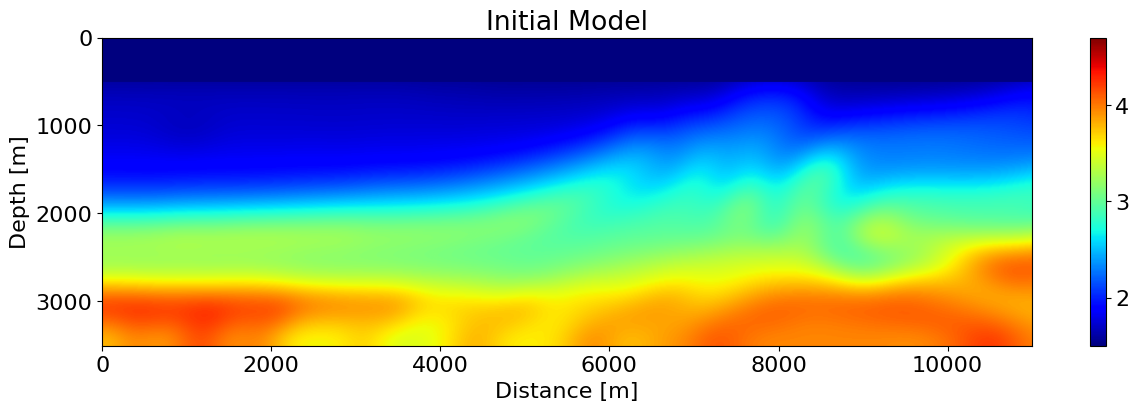

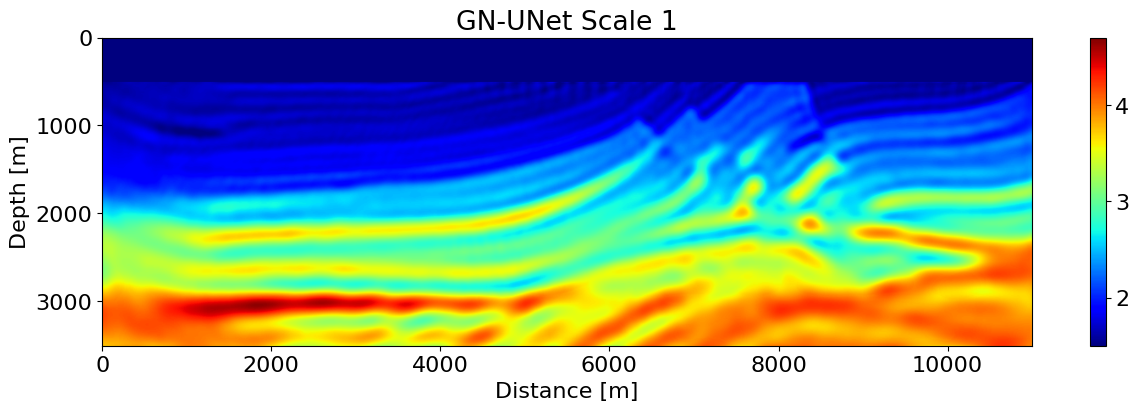

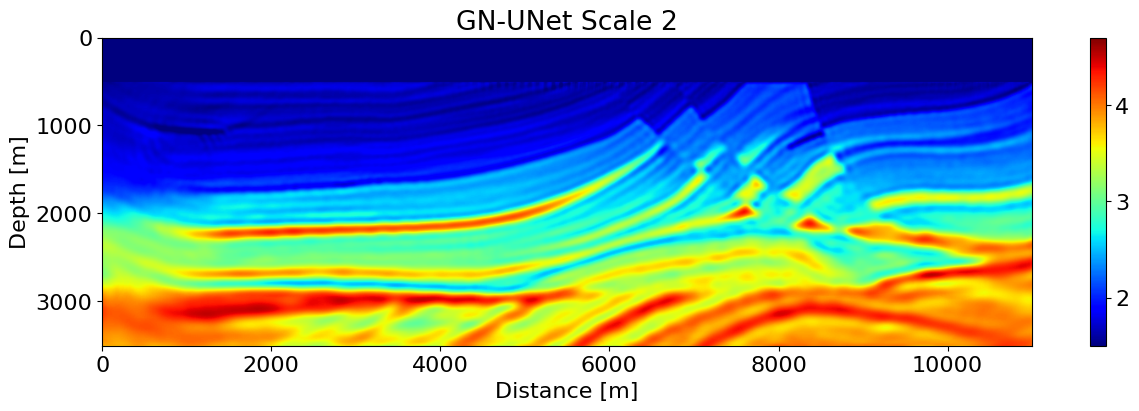

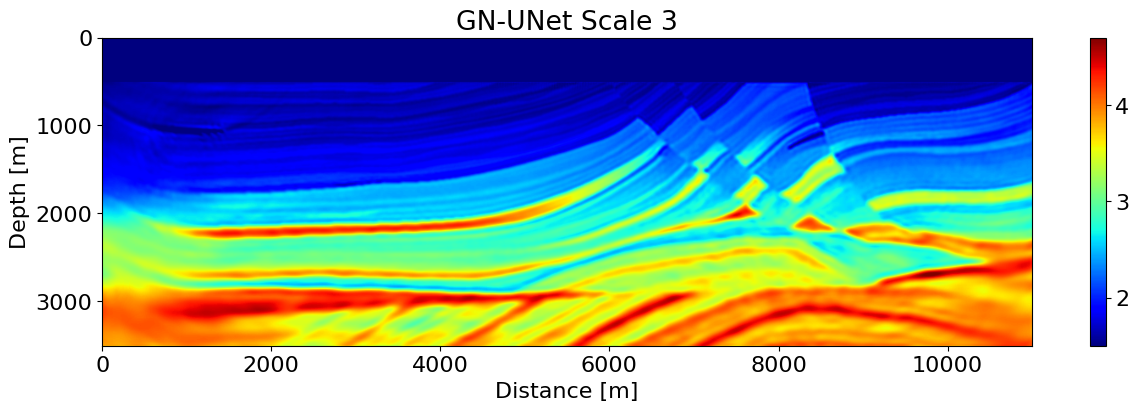

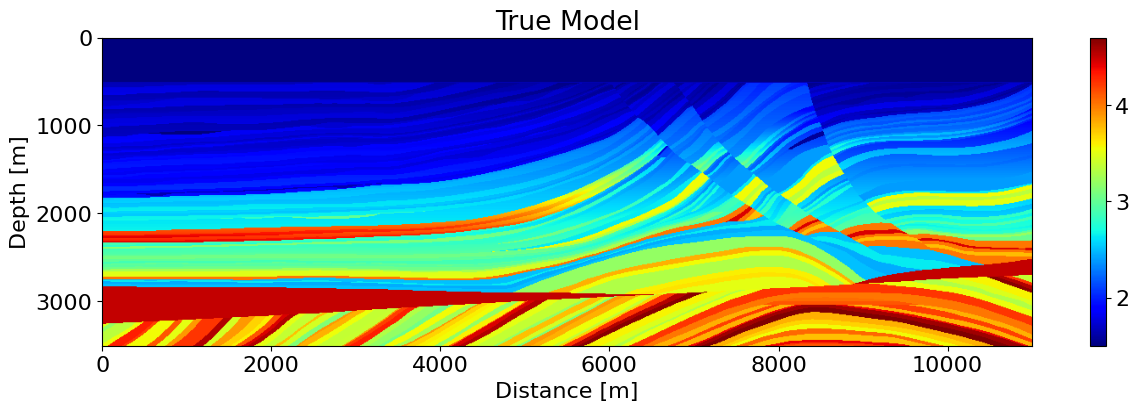

In [6]:
vp1 = np.loadtxt(f'model_progress/marm_born_trial/scale1/model_monitor.txt')
vp2 = np.loadtxt(f'model_progress/marm_born_trial/scale2/model_monitor.txt')
vp3 = np.loadtxt(f'model_progress/marm_born_trial/scale3/model_monitor.txt')

vp1 = np.loadtxt(f'model_progress/marm_born_trial/scale1/model_monitor.txt')
vp2 = np.loadtxt(f'model_progress/marm_born_trial/scale2/model_monitor.txt')
vp3 = np.loadtxt(f'model_progress/marm_born_trial/scale3/model_monitor.txt')

shape = (1100, 351)
spacing = (10, 10)
origin = (0, 0)

vm = 0.1
shrink=1
figsize=(15,4)
extent = (0, 11000, 3510, 0)

plt.figure(figsize=figsize)
plt.title('Initial Model')
plt.xlabel('Distance [m]')
plt.ylabel('Depth [m]')
cb = plt.imshow(init[:1100].T, aspect='auto', cmap='jet', vmin=1.5, vmax=4.7, extent=extent)
plt.colorbar(cb, shrink=shrink)

plt.figure(figsize=figsize)
plt.title('GN-UNet Scale 1')
plt.xlabel('Distance [m]')
plt.ylabel('Depth [m]')
cb = plt.imshow(vp1, aspect='auto', cmap='jet', vmin=1.5, vmax=4.7, extent=extent)
plt.colorbar(cb, shrink=shrink)

plt.figure(figsize=figsize)
plt.title('GN-UNet Scale 2')
plt.xlabel('Distance [m]')
plt.ylabel('Depth [m]')
cb = plt.imshow(vp2, aspect='auto', cmap='jet', vmin=1.5, vmax=4.7, extent=extent)
plt.colorbar(cb, shrink=shrink)

plt.figure(figsize=figsize)
plt.title('GN-UNet Scale 3')
plt.xlabel('Distance [m]')
plt.ylabel('Depth [m]')
cb = plt.imshow(vp3, aspect='auto', cmap='jet', vmin=1.5, vmax=4.7, extent=extent)
plt.colorbar(cb, shrink=shrink)

plt.figure(figsize=figsize)
plt.title('True Model')
plt.xlabel('Distance [m]')
plt.ylabel('Depth [m]')
cb = plt.imshow(v[:1100].T, aspect='auto', cmap='jet', vmin=1.5, vmax=4.7, extent=extent)
plt.colorbar(cb, shrink=shrink)

plt.show()